# COVID-19 ML Modeling for Disease Severity

Data can be found __[here](https://data.cdc.gov/Case-Surveillance/COVID-19-Case-Surveillance-Public-Use-Data/vbim-akqf)__. Data is updated monthly. Last updated 02/05/2021

## Import Packages

In [1]:
import pandas as pd 
import numpy as np
import dask.dataframe as dd 
import dask.array as da 

import time

# Plotting
import matplotlib.pyplot as plt
import seaborn as sns
import plotly_express as px

#plt.style.use('fivethirtyeight')

# Statistical Analysis
import pingouin as pg

import statsmodels.api as sm
import statsmodels.formula.api as smf
import statsmodels.stats.api as sms

from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.stats.multicomp import pairwise_tukeyhsd

from statsmodels.regression.linear_model import OLS
from statsmodels.formula.api import ols
from statsmodels.graphics.gofplots import ProbPlot
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.nonparametric.smoothers_lowess import lowess

from scipy.stats import pearsonr, ttest_ind, norm, chi2_contingency, fisher_exact, spearmanr

import scipy.stats as stats

#Machine Learning Packages
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis, QuadraticDiscriminantAnalysis
from sklearn.naive_bayes import GaussianNB
from xgboost import XGBClassifier

from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV

import shap
shap.initjs()

# Notebook display modifications
from IPython.core.display import display
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

pd.set_option('display.float_format', lambda x: '%.3f' % x)
np.set_printoptions(suppress=True)

# Printing Text Formatting
class color:
    PURPLE = '\033[95m'
    CYAN = '\033[96m'
    DARKCYAN = '\033[36m'
    BLUE = '\033[94m'
    GREEN = '\033[92m'
    YELLOW = '\033[93m'
    RED = '\033[91m'
    BOLD = '\033[1m'
    UNDERLINE = '\033[4m'
    END = '\033[0m'

from sklearn.metrics import *    
from sklearn.model_selection import train_test_split

C:\Users\Eric\Anaconda3\lib\site-packages\outdated\utils.py:18: OutdatedPackageWarning: The package pingouin is out of date. Your version is 0.3.8, the latest is 0.3.9.
Set the environment variable OUTDATED_IGNORE=1 to disable these warnings.
  **kwargs


## Define Helper Functions

In [10]:
######################################################################################################################################
###################################################### MODEL SCORING METRICS #########################################################
######################################################################################################################################

# Model Scoring Metrics       
def MAPE(y_actual,y_pred):

  '''
  Function Name: MAPE

  Arguments:

  - y_actual: A Numpy Array or Pandas Series. The actual response values from the Test Set

  - y_pred: A Numpy Array or Pandas Series. The predicted response values from the ML Model

  Returns:

  Returns the Mean Absolute Percentage Error of the predicted values.

  '''
  return np.mean(np.abs((y_actual - y_pred) / y_actual)) * 100

def MSE(y_actual, y_pred):

    '''
    Function Name: MSE

    Arguments:

    - y_actual: A Numpy Array or Pandas Series. The actual response values from the Test Set

    - y_pred: A Numpy Array or Pandas Series. The predicted response values from the ML Model

    Returns:

    Returns the Mean Squared Error of the predicted values.
  
    '''
    return np.mean( (y_actual - y_pred) **2)

def RMSE(y_actual,y_pred):

    '''
    Function Name: RMSE

    Arguments:

    - y_actual: A Numpy Array or Pandas Series. The actual response values from the Test Set

    - y_pred: A Numpy Array or Pandas Series. The predicted response values from the ML Model

    Returns:

    Returns the Root Mean Squared Error of the predicted values.

    '''
    return np.sqrt( np.mean( (y_actual - y_pred) **2) )

def MAE(y_actual, y_pred):

    '''
    Function Name: MAE

    Arguments:

    - y_actual: A Numpy Array or Pandas Series. The actual response values from the Test Set

    - y_pred: A Numpy Array or Pandas Series. The predicted response values from the ML Model

    Returns:

    Returns the Mean Absolute Error of the predicted values.

    '''
    return np.mean( np.abs( y_actual - y_pred ) )

def TPR_FPR_Score(y_actual, y_pred):

    '''
    Function Name: TPR_FPR_Score

    Arguments:

    - y_actual: A Numpy Array or Pandas Series. The actual response values from the Test Set.

    - y_pred: A Numpy Array or Pandas Series. The actual response values from the ML Model.

    Returns:

    Returns the True Positive Rate and the False Positive Rate for a given Classifier.

    '''

    tab = pd.crosstab(y_actual,y_pred,margins=True)

    tpr = tab.iloc[1,1] / tab.iloc[1,-1]
    fpr = tab.iloc[0,1] / tab.iloc[-1,1]

    return tpr, fpr

def Outlier_Detect(dataframe, column):
    '''
    Function Name: Outlier_Detect

    Arguments:

    - dataframe: A Pandas DataFrame object

    - column: A String corresponding to the name of the column that you are using to look for outliers

    Returns:

    A Numpy Array with 1s and 0s, with 1s corresponding to an observation being an outlier, and 0s meaning
    not an outlier.

    Description:

    A function to detect outliers for a single variable. Uses 1.5 +- Times the Inter Quartile Range of the variable
    passed into the function, and marks points above or below that threshold as outliers with a 1. 
    '''
    IQR = dataframe[column].describe()[6] - dataframe[column].describe()[4]
    
    conditions = [
        
        ( dataframe[column]> dataframe[column].median() + (1.5*IQR) ),
        ( dataframe[column]< dataframe[column].median() - (1.5*IQR) )
    ]
    
    vals = [1,1]
    
    return np.select(conditions,vals,default=0)

######################################################################################################################################
################################################## PLOTTING HELPER FUNCTIONS #########################################################
######################################################################################################################################

def bar(x,y,data,title='', order=None, alpha=0.01):

    '''
    Function Name: bar

    Arguments:

    - x: A String that corresponds to the name of the column in the Pandas DataFrame object
         that should be used as the aggregation or x variable. Should be a categorical variable.

    - y: A String that corresponds to the name of the column in the Pandas DataFrame object
         that should be used as the response variable. Can be either categorical or continuious.

    - data: A Pandas DataFrame object

    - title: A String that will be the title of the Barchart that is returned.

    - order: The order that the names of the categories of the x variables should take. By Default,
             the data is sorted by Descending Order of the values of y, but a custom order can be passed
             in the case that there is a particular order that makes more sense than sorting highest
             to lowest based on the response variable. An example of a custom order that could be passed
             is the names of the months of the year. While the y variable on average might be higher in
             March as compared to January, it might be more visually appealing to see the data sorted by
             the months of the year instead of the value of the response variable.

    - alpha: The level of significance to be used in either an ANOVA+Tukey HSD test, or a Chi Squared test of
             Independence, depending on if the response variable is continuious or categorical.

    Returns:

    Returns either an ANOVA Table + Tukeys HSD Multiple Comparison of Means table and a bar chart, or the results
    of a Chi Squared test of Independence + Expected and Actual Counts from the IxJ table, and a bar chart, 
    depending on if y is continuious or categorical, respectively.For categorical response variables, statements 
    about rejecting or failing to reject the null hypothesis are returned, as well as information about the p-value.

    Description:

    A function to generate a barchart, that is flexible and able to detect if the response variable is categorical or continuious,
    and then conduct the appropriate statistical tests to see if the response variable differs across different levels of the 
    independent/x variable.
    '''

    if order == None:
        order = list(data.groupby(x)[y].mean().index)
    else:
        order = order
    
    numeric_dtypes = [np.int, np.int0, np.int8, np.int16, np.int32, np.int64, np.float, np.float16, np.float32, np.float64, np.float128]
    
    if type(data[y][0]) in numeric_dtypes:
        plt.figure(figsize=(17,9))
        plt.title(title)
        sns.barplot(x,y,data=data,order=order)
        plt.xlabel(x)
        plt.ylabel(y)

        aov = pg.anova(dv=y, between=x, data=data, detailed=True)
        posthocs = pairwise_tukeyhsd(data[y],data[x],alpha=alpha)
        print(posthocs)
        display(pd.DataFrame(data.groupby(x)[y].mean().sort_values(ascending=False)))
        display(aov)
    
    else:
        
        plt.figure(figsize=(17,9))
        plt.title(title)
        sns.barplot(x,y,data=data,order=order)
        plt.xlabel(x)
        plt.ylabel(y)
        
        g, p, dof, expctd = chi2_contingency(np.array(pd.crosstab(data[x], data[y])))
        
        expctd = pd.DataFrame(expctd)
        expctd.index = pd.crosstab(data[x], data[y]).index
        
        if p < alpha:
            print(f"The Chi-Squared statistic is: {round(g,2)}. The p-value is: {round(p,5)}. Since the p-value is less than {alpha}, we reject\nthe null hypothesis and conclude that there is a relationship between {df[x].name} and {df[y].name}.")
        else:
            print(f"The Chi-Squared statistic is: {round(g,2)}. The p-value is: {round(p,5)}. Since the p-value is greater than {alpha}, we FAIL TO REJECT\nthe null hypothesis and conclude that there is NO relationship between {df[x].name} and {df[y].name}.")
        
        print("\n")
        print(f"If {df[x].name} and {df[y].name} were independent, then first table below contains what the expected counts would be.\nThe second table is actual counts.")
        print("\nTable of Expected Counts")
        display(expctd)
        print("\nTable of Actual Counts") 
        display(pd.crosstab(data[x], data[y]))


def scatter(x,y,data,title='', alpha=0.01):

    '''
    Function Name: scatter

    Arguments:

    - x: A String that corresponds to the name of the column in the Pandas DataFrame object
         that should be used as the aggregation or x variable. Should be a continuious variable.

    - y: A String that corresponds to the name of the column in the Pandas DataFrame object
         that should be used as the response variable. Should be a continuious variable.

    - data: A Pandas DataFrame object

    - title: A String that will be the title of the Barchart that is returned.

    - xlims: The lower and upper bounds of the range of x-values to be shown on the x-axis of the scatter plot.
             Default is 0 to 100, but should be adjusted based on your data.

    Returns:

    Returns a Seaborn RegPlot showing the relationship between x and y, as well as the pearson correlation
    between x and y, and the associated p-value for that pearson correlation.

    Description:

    A function to generate a scatter plot between two continuious variables and see if the linear relationship
    between the two variables is statistically significant.
    '''

    plt.figure(figsize=(17,9))
    plt.title(title)
    sns.regplot(x,y,data=data)
    plt.xlabel(x)
    plt.ylabel(y)

    corr = pearsonr(data[x],data[y])[0]
    pval = pearsonr(data[x],data[y])[1]

    if pval < alpha:
        print("The Correlation between "+ x + " and " + y +f" is: {corr}.\nThe p-value is: {pval}.\nThe correlation is significant")
    else:
        print("The Correlation between "+ x + " and " + y +f" is: {corr}.\nThe p-value is: {pval}.\nThe correlation is NOT significant")

######################################################################################################################################
######################################## LINEAR REGRESSION DIAGNOSTICS HELPER FUNCTIONS ##############################################
######################################################################################################################################

# Regression Diagnostic plots

def diagnostic_plots(X, y, model_fit=None, log_response=False):
    
    """
    Function to reproduce the 4 base plots of an OLS model in R. 2 Additional plots are created that are not part of the
    base 4 plots in R. Those extra two plots are a KDE plot to show the distribution of the model residuals, and a regplot
    showing the relationship between the predicted values from the model and the actual values of the response variable, to
    allow the user to get a sense of how accurate the model's predictions are in reality.

    ---
    Inputs:

    X: A numpy array or pandas dataframe of the features to use in building the linear regression model

    y: A numpy array or pandas series/dataframe of the target variable of the linear regression model

    model_fit [optional]: a statsmodel.api.OLS model after regressing y on X. If not provided, will be
                        generated from X, y
    """
    if log_response == False:
        if not model_fit:
            model_fit = sm.OLS(y, sm.add_constant(X)).fit()

        # create dataframe from X, y for easier plot handling
        dataframe = pd.concat([X, y], axis=1)

        # model values
        model_fitted_y = model_fit.fittedvalues
        # model residuals
        model_residuals = model_fit.resid
        # normalized residuals
        model_norm_residuals = model_fit.get_influence().resid_studentized_internal
        # absolute squared normalized residuals
        model_norm_residuals_abs_sqrt = np.sqrt(np.abs(model_norm_residuals))
        # absolute residuals
        model_abs_resid = np.abs(model_residuals)
        # leverage, from statsmodels internals
        model_leverage = model_fit.get_influence().hat_matrix_diag
        # cook's distance, from statsmodels internals
        model_cooks = model_fit.get_influence().cooks_distance[0]
        
        fig, axs = plt.subplots(3,2, figsize=(17,17))
        
        
        # Residuals vs Fitted Plot
        sns.residplot(model_fitted_y, dataframe.columns[-1], data=dataframe,
                                lowess=True,
                                scatter_kws={'alpha': 0.5},
                                line_kws={'color': 'red', 'lw': 1, 'alpha': 0.8},
                                ax=axs[0][0])

        axs[0][0].set_title('Residuals vs Fitted')
        axs[0][0].set_xlabel('Fitted values')
        axs[0][0].set_ylabel('Residuals');

        # Annotating the Residuals vs Fitted Plot
        abs_resid = model_abs_resid.sort_values(ascending=False)
        abs_resid_top_3 = abs_resid[:3]
        for i in abs_resid_top_3.index:
            axs[0][0].annotate(i,
                                xy=(model_fitted_y[i],
                                    model_residuals[i]));
            
            
        # QQ Norm Plot
        QQ = ProbPlot(model_norm_residuals)    
            
        ProbPlot(model_norm_residuals).qqplot(line='45', alpha=0.5, color='#4C72B0', lw=1,ax=axs[0][1])
        axs[0][1].set_title('Normal Q-Q')
        axs[0][1].set_xlabel('Theoretical Quantiles')
        axs[0][1].set_ylabel('Standardized Residuals');
        
        # Annotating the QQ Norm Plot
        abs_norm_resid = np.flip(np.argsort(np.abs(model_norm_residuals)), 0)
        abs_norm_resid_top_3 = abs_norm_resid[:3]
        for r, i in enumerate(abs_norm_resid_top_3):
            axs[0][1].annotate(i,
                                     xy=(np.flip(QQ.theoretical_quantiles, 0)[r],
                                         model_norm_residuals[i]));

            
        # Scale vs Location Plot    
        sns.regplot(model_fitted_y, model_norm_residuals_abs_sqrt,
                  scatter=True,
                  ci=False,
                  lowess=True,
                  line_kws={'color': 'red', 'lw': 1, 'alpha': 0.8},
                  ax=axs[1][0]);
        axs[1][0].set_title('Scale-Location')
        axs[1][0].set_xlabel('Fitted values')
        axs[1][0].set_ylabel('$\sqrt{|Standardized Residuals|}$');

        # Annotating the Scale vs Location Plot
        abs_sq_norm_resid = np.flip(np.argsort(model_norm_residuals_abs_sqrt), 0)
        abs_sq_norm_resid_top_3 = abs_sq_norm_resid[:3]
        for i in abs_norm_resid_top_3:
            axs[1][0].annotate(i,
                                     xy=(model_fitted_y[i],
                                         model_norm_residuals_abs_sqrt[i]));
            
        # Residuals vs Leverage Plot    
        student_residuals = pd.Series(model_fit.get_influence().resid_studentized_internal)
        student_residuals.index = model_fit.resid.index
        res_df = pd.DataFrame(student_residuals)
        res_df.columns = ['student_residuals']
        res_df['leverage'] = model_fit.get_influence().hat_matrix_diag
        smoothed = lowess(res_df['student_residuals'],res_df['leverage'])
        sorted_student_residuals = abs(res_df['student_residuals']).sort_values(ascending = False)
        top3 = sorted_student_residuals[:3]

        lev_x = res_df['leverage']
        res_y = res_df['student_residuals']
        xpos = max(lev_x)+max(lev_x)*0.01  
        axs[1][1].scatter(lev_x, res_y)
        axs[1][1].plot(smoothed[:,0],smoothed[:,1],color = 'r')
        axs[1][1].set_ylabel('Studentized Residuals')
        axs[1][1].set_xlabel('Leverage')
        axs[1][1].set_title('Residuals vs. Leverage')

        # Annotating the Residuals vs Leverage Plot
        for val in top3.index:
            axs[1][1].annotate(val,xy=(lev_x.loc[val],res_y.loc[val]))

        cooksx = np.linspace(min(lev_x), xpos, 50)
        p = len(model_fit.params)
        poscooks1y = np.sqrt((p*(1-cooksx))/cooksx)
        poscooks05y = np.sqrt(0.5*(p*(1-cooksx))/cooksx)
        negcooks1y = -np.sqrt((p*(1-cooksx))/cooksx)
        negcooks05y = -np.sqrt(0.5*(p*(1-cooksx))/cooksx)
        
        # Putting the individual plot components on the subplot
        axs[1][1].plot(cooksx,poscooks1y,label = "Cook's Distance", ls = ':', color = 'r')
        axs[1][1].plot(cooksx,poscooks05y, ls = ':', color = 'r')
        axs[1][1].plot(cooksx,negcooks1y, ls = ':', color = 'r')
        axs[1][1].plot(cooksx,negcooks05y, ls = ':', color = 'r')
        axs[1][1].annotate('1.0', xy = (xpos, poscooks1y[-1]), color = 'r')
        axs[1][1].annotate('0.5', xy = (xpos, poscooks05y[-1]), color = 'r')
        axs[1][1].annotate('1.0', xy = (xpos, negcooks1y[-1]), color = 'r')
        axs[1][1].annotate('0.5', xy = (xpos, negcooks05y[-1]), color = 'r')
        axs[1][1].legend(loc='upper right')

        # Distribution of Residuals Plot
        sns.distplot(model_residuals, ax=axs[2][0]);
        axs[2][0].set_title('Distribution of Standardized Model Residuals');

        # Predicted vs Actuals Plot
        sns.regplot(x=model_fitted_y,y=y, ax=axs[2][1]);
        axs[2][1].set_title('Predicted vs Actual Values')
        axs[2][1].set_xlabel('Predicted Values')
        axs[2][1].set_ylabel('Actual Values');

        # Model Diagnostics
        print(f"The Mean of the Residuals is:                       {np.mean(model_residuals)}")
        print(f"The Mean Absolute Percentage Error of the Model is: {MAPE(y,model_fitted_y)}%")
        print(f"The Mean Squared Error of the Model is:             {MSE(y,model_fitted_y)}")
        print(f"The Root Mean Squared Error of the Model is:        {RMSE(y,model_fitted_y)}")
        print(f"The Mean Absolute Error of the Model is:            {MAE(y,model_fitted_y)}")
        
    else:
        if not model_fit:
            model_fit = sm.OLS(y, sm.add_constant(X)).fit()

        # create dataframe from X, y for easier plot handling
        dataframe = pd.concat([X, y], axis=1)

        # model values
        model_fitted_y = model_fit.fittedvalues
        # model residuals
        model_residuals = model_fit.resid
        # normalized residuals
        model_norm_residuals = model_fit.get_influence().resid_studentized_internal
        # absolute squared normalized residuals
        model_norm_residuals_abs_sqrt = np.sqrt(np.abs(model_norm_residuals))
        # absolute residuals
        model_abs_resid = np.abs(model_residuals)
        # leverage, from statsmodels internals
        model_leverage = model_fit.get_influence().hat_matrix_diag
        # cook's distance, from statsmodels internals
        model_cooks = model_fit.get_influence().cooks_distance[0]
        
        fig, axs = plt.subplots(3,2, figsize=(17,14))
        
        
        # Residuals vs Fitted Plot
        sns.residplot(model_fitted_y, dataframe.columns[-1], data=dataframe,
                                lowess=True,
                                scatter_kws={'alpha': 0.5},
                                line_kws={'color': 'red', 'lw': 1, 'alpha': 0.8},
                                ax=axs[0][0])

        axs[0][0].set_title('Residuals vs Fitted')
        axs[0][0].set_xlabel('Fitted values')
        axs[0][0].set_ylabel('Residuals');

        # Annotating the Residuals vs Fitted Plot
        abs_resid = model_abs_resid.sort_values(ascending=False)
        abs_resid_top_3 = abs_resid[:3]
        for i in abs_resid_top_3.index:
            axs[0][0].annotate(i,
                                xy=(model_fitted_y[i],
                                    model_residuals[i]));
            
            
        # QQ Norm Plot
        QQ = ProbPlot(model_norm_residuals)    
            
        ProbPlot(model_norm_residuals).qqplot(line='45', alpha=0.5, color='#4C72B0', lw=1,ax=axs[0][1])
        axs[0][1].set_title('Normal Q-Q')
        axs[0][1].set_xlabel('Theoretical Quantiles')
        axs[0][1].set_ylabel('Standardized Residuals');
        
        # Annotating the QQ Norm Plot
        abs_norm_resid = np.flip(np.argsort(np.abs(model_norm_residuals)), 0)
        abs_norm_resid_top_3 = abs_norm_resid[:3]
        for r, i in enumerate(abs_norm_resid_top_3):
            axs[0][1].annotate(i,
                                     xy=(np.flip(QQ.theoretical_quantiles, 0)[r],
                                         model_norm_residuals[i]));

            
        # Scale vs Location Plot    
        sns.regplot(model_fitted_y, model_norm_residuals_abs_sqrt,
                  scatter=True,
                  ci=False,
                  lowess=True,
                  line_kws={'color': 'red', 'lw': 1, 'alpha': 0.8},
                  ax=axs[1][0]);
        axs[1][0].set_title('Scale-Location')
        axs[1][0].set_xlabel('Fitted values')
        axs[1][0].set_ylabel('$\sqrt{|Standardized Residuals|}$');

        # Annotating the Scale vs Location Plot
        abs_sq_norm_resid = np.flip(np.argsort(model_norm_residuals_abs_sqrt), 0)
        abs_sq_norm_resid_top_3 = abs_sq_norm_resid[:3]
        for i in abs_norm_resid_top_3:
            axs[1][0].annotate(i,
                                     xy=(model_fitted_y[i],
                                         model_norm_residuals_abs_sqrt[i]));
            
            
        # Residuals vs Leverage Plot    
        student_residuals = pd.Series(model_fit.get_influence().resid_studentized_internal)
        student_residuals.index = model_fit.resid.index
        res_df = pd.DataFrame(student_residuals)
        res_df.columns = ['student_residuals']
        res_df['leverage'] = model_fit.get_influence().hat_matrix_diag
        smoothed = lowess(res_df['student_residuals'],res_df['leverage'])
        sorted_student_residuals = abs(res_df['student_residuals']).sort_values(ascending = False)
        top3 = sorted_student_residuals[:3]

        lev_x = res_df['leverage']
        res_y = res_df['student_residuals']
        xpos = max(lev_x)+max(lev_x)*0.01  
        axs[1][1].scatter(lev_x, res_y)
        axs[1][1].plot(smoothed[:,0],smoothed[:,1],color = 'r')
        axs[1][1].set_ylabel('Studentized Residuals')
        axs[1][1].set_xlabel('Leverage')
        axs[1][1].set_title('Residuals vs. Leverage')

        # Annotating the Residuals vs Leverage Plot
        for val in top3.index:
            axs[1][1].annotate(val,xy=(lev_x.loc[val],res_y.loc[val]))

        cooksx = np.linspace(min(lev_x), xpos, 50)
        p = len(model_fit.params)
        poscooks1y = np.sqrt((p*(1-cooksx))/cooksx)
        poscooks05y = np.sqrt(0.5*(p*(1-cooksx))/cooksx)
        negcooks1y = -np.sqrt((p*(1-cooksx))/cooksx)
        negcooks05y = -np.sqrt(0.5*(p*(1-cooksx))/cooksx)
        
        # Putting the individual plot components on the subplot
        axs[1][1].plot(cooksx,poscooks1y,label = "Cook's Distance", ls = ':', color = 'r')
        axs[1][1].plot(cooksx,poscooks05y, ls = ':', color = 'r')
        axs[1][1].plot(cooksx,negcooks1y, ls = ':', color = 'r')
        axs[1][1].plot(cooksx,negcooks05y, ls = ':', color = 'r')
        axs[1][1].annotate('1.0', xy = (xpos, poscooks1y[-1]), color = 'r')
        axs[1][1].annotate('0.5', xy = (xpos, poscooks05y[-1]), color = 'r')
        axs[1][1].annotate('1.0', xy = (xpos, negcooks1y[-1]), color = 'r')
        axs[1][1].annotate('0.5', xy = (xpos, negcooks05y[-1]), color = 'r')
        axs[1][1].legend(loc='upper right')
        

        # Distribution of Residuals Plot
        sns.distplot(model_residuals, ax=axs[2][0]);
        axs[2][0].set_title('Distribution of Model Residuals');
        

        # Predicted vs Actuals Plot
        sns.regplot(x=np.exp(model_fitted_y),y=np.exp(y), ax=axs[2][1]);
        axs[2][1].set_title('Predicted vs Actual Values')
        axs[2][1].set_xlabel('Predicted Values')
        axs[2][1].set_ylabel('Actual Values');
        
        # Model Diagnostics
        print(f"The Mean of the Residuals is:                       {np.mean(model_residuals)}")
        print(f"The Mean Absolute Percentage Error of the Model is: {MAPE(np.exp(y), np.exp(model_fitted_y))}%")
        print(f"The Mean Squared Error of the Model is:             {MSE(np.exp(y),  np.exp(model_fitted_y))}")
        print(f"The Root Mean Squared Error of the Model is:        {RMSE(np.exp(y), np.exp(model_fitted_y))}")
        print(f"The Mean Absolute Error of the Model is:            {MAE(np.exp(y),  np.exp(model_fitted_y))}")


def vif(X):
    '''
    Function Name: vif

    Arguments:

    - X: A Pandas Dataframe of predictor variables. Should have a column of constants to get correct VIF values.

    Returns:

    A Pandas DataFrame object with 2 columns, "VIF Factor" and "Predictors", showing what the VIF values are for each
    of the predictors in the X dataframe

    Description:

    A Function to calculate the Variance Inflation Factor for each predictor in a set of predictor variables. Helpful in 
    removing variables that are highly correlated or co-linear.
    
    '''
    vifdf = pd.DataFrame()
    vifdf["VIF Factor"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
    vifdf["Predictors"] = X.columns
    
    return vifdf

######################################################################################################################################
################################################ STATISTICAL HELPER FUNCTIONS ########################################################
######################################################################################################################################



def oddsratio_ci(obs, alpha=0.05):

    '''
    Function Name: oddsratio_ci

    Arguments:

    - obs: A 2x2 contingency table of observations. Can either be a Numpy Array, or a Pandas Crosstab object.

    - alpha: 1 - The desired confidence level of the test.

    Returns:

    - Returns a string that says what the 1 - alpha % confidence interval for the Estimated Odds Ratio is.

    Description:

    This function takes in a 2x2 contingency table of observations and returns a string that says what the 1 - alpha % confidence interval for the Estimated Odds Ratio comparing row 1 to row 2 is. 
    Provides the lower and upper bounds of the confidence interval, and alerts the user if the interval contains 1.
    
    '''
    
    import scipy.stats as stats
    
    oddsratio = ( (obs[0][0] * obs[1][1]) / (obs[1][0] * obs[0][1]))
    
    if oddsratio < 1:
        oddsratio = 1/oddsratio
    else:
        oddsratio = oddsratio
        
    logor = np.log(oddsratio)
    
    z = stats.norm.ppf(1 - (alpha/2))
    
    se = np.sqrt( (1/obs[0][0]) + (1/obs[0][1]) + (1/obs[1][0]) + (1/obs[1][1]) )
    
    lb = np.exp( logor - (z*se))
    ub = np.exp( logor + (z*se))
    
    print(f"The {str(round(1-alpha,6)*100)}% Confidence Interval for the Estimated Oddsratio is: ({lb}, {ub})")
    
    if lb <=1:
        print(f"The Confidence Interval for the Estimated Odds Ratio Contains 1, and thus the Estimated Odds Ratio\nis not Statistically Significantly different from 1.")

def clean_ttest(a,b,equal_var=False, alpha=0.05, group_a_name='', group_b_name='', variable_of_interest=''):

    '''
    Function Name: clean_ttest

    Arguments:

    - a: A Numpy Array or Pandas Series for the variable that you want to compare for Group A

    - b: A Numpy Array or Pandas Series for the variable that you want to compare for Group B

    - equal_var (Default=False): A boolean value to indicate if you want the ttest to assume equal variance between the two arrays. Default is False.

    - alpha: A float for the 1-Confidence Level value.

    - group_a_name: A String that describes Group A. For example, if comparing average weight of two genders, you could name Group A "Men" and Group B "Women" 

    - group_b_name: A String that describes Group B. For example, if comparing average weight of two genders, you could name Group A "Men" and Group B "Women" 

    - variable_of_interest: A String that describes what the variable of interest is. In the above examples, "Weight" would be an appropriate name, because
                            we are interested in comparing the average weight of men and women.


    Returns:

    - Returns a string that says what the 1 - alpha % confidence interval for the Estimated Odds Ratio is.

    Description:

    This function takes in two arrays that are split by some categorical variable. For example, you could pass in
    the weights for men and women into a,b respectively. The function then computes the p-value that allows you to 
    test the null hypothesis that the two sample means are equal.

    The function also returns statements that say if we reject, or fail to reject the null hypothesis, and it shows
    the difference in means between the two samples. It also returns KDE/Distribution plots for both samples, to 
    allow the user to visually inspect the distributions of both samples.
    
    '''

    class color:
        PURPLE = '\033[95m'
        CYAN = '\033[96m'
        DARKCYAN = '\033[36m'
        BLUE = '\033[94m'
        GREEN = '\033[92m'
        YELLOW = '\033[93m'
        RED = '\033[91m'
        BOLD = '\033[1m'
        UNDERLINE = '\033[4m'
        END = '\033[0m'
    
    from scipy.stats import ttest_ind
    
    test_stat, p_val = ttest_ind(a,b,equal_var=equal_var)
    
    
    print("="*125)
    print("\n\t\t\t\t\t\t T-Test of Independence")
    print("\n\n")
    print("H0: There is no significant difference between the two means, i.e. μ1 = μ2")
    print("\n")
    print("HA: There is a significant difference between the two means, i.e. μ1 ≠ μ2\n\n")
    
    
    if p_val > alpha:
        print(f"The p-value is: {p_val}, which is greater than {alpha}, thus we" + color.BOLD + " FAIL TO REJECT THE NULL HYPOTHESIS" + color.END + f" and\nconclude that there is no significant difference between the means of")
        print("\n")
    else:
        print(f"The p-value is: {p_val}, which is smaller than {alpha}, thus we" + color.BOLD + " REJECT THE NULL HYPOTHESIS" + color.END + f" and conclude that\nthere is a significant difference between the means")
        if a.mean() - b.mean() >= 0:
            print("\n")
            print(f"The difference in means between {group_a_name} and {group_b_name} ({group_a_name} Average - {group_b_name} Average) is: {round(a.mean() - b.mean(),2)}, Meaning that {group_a_name} has {round(a.mean() - b.mean(),2)} more {variable_of_interest} on average than {group_b_name}.")
        else:
            print("\n")
            print(f"The difference in means between {group_b_name} and {group_a_name} ({group_b_name} Average - {group_a_name} Average) is: {round(b.mean() - a.mean(),2)}, Meaning that {group_b_name} has {round(b.mean() - a.mean(),2)} more {variable_of_interest} on average than {group_a_name}.")
    print("\n")
    print("="*125)
    print("\n")
    
    plt.figure(figsize=(17,9))
    plt.title("Comparing the Distributions of " + variable_of_interest + " Between " + group_a_name + " And " + group_b_name)
    sns.histplot(a, label=group_a_name, kde=True, color='#004CEE')
    sns.histplot(b, label=group_b_name, kde=True, color='#EA0808')
    plt.legend()
 

def contingency_table_summary(table, success='', failure='', treatment1='', treatment0='', alpha=0.01):

    '''
    Function Name: contingency_table_summary

    Arguments:

    - table: A pandas.crosstab object or a numpy array

    - success: A String that defines what the "Success" outcome is in this scenario

    - failure: A String that defines what the opposite of the "Success" outcome is in this scenario

    - treatment1: A String that describes what the treatment is in row one. For example, if you wanted
                  to look at the impact of wearing a helmet and if someone sustains a head injury while
                  riding a bicycle, then treatment 1 would be the affirmative case where someone is 
                  wearing a helmet

    - treatment0: A String that describes what the treatment is in row two. In relation to the above 
                  example, treatment0 would be someone not wearing a helmet.

    - alpha: The level of significance to use. Default is 0.01

    Returns:

    1. Table of expected Counts
    2. Table of Actual Counts
    3. Statements about the Estimated Odds Ratio, p-value, and if we should reject or fail to 
       reject the null hypothesis.

    Description:

    This function takes in a 2x2 contingency table and calculates the Estimated Odds Ratio comparing
    row 1 to row 2. It also calculates the G-Squared statistic, and p-value, as well as the 1-alpha%
    confidence interval for the Estimated Odds Ratio. It also give statements about the significance
    of the chi_squared test, and Estimated Odds Ratio, and provides guidence about rejecting or 
    failing to reject the null hypothesis that the two variables are independent.
    
    '''     

    from IPython.display import display

    if type(table) ==  pd.core.frame.DataFrame:  
      obs = np.array([
      
              # Failure = 0   # Success = 1
              [table.iloc[0,0], table.iloc[0,1]], #Control = 0
              [table.iloc[1,0], table.iloc[1,1]], #Treatment   = 1
      
          ])
    else:
        obs = table

    oddsratio, pvalue = fisher_exact(obs)

    g, p, dof, expctd = chi2_contingency(obs, lambda_="log-likelihood")

    expctd = pd.DataFrame(expctd)

    if type(table) == pd.core.frame.DataFrame:
        expctd.index.name   = table.index.name
        expctd.columns.name = table.columns.name
    else:
        expctd.index.name   = treatment1
        expctd.columns.name = success

    obs = pd.DataFrame(obs)

    if type(table) == pd.core.frame.DataFrame:
        obs.index.name   = table.index.name
        obs.columns.name = table.columns.name
    else:
        obs.index.name   = treatment1
        obs.columns.name = success

    print(f"The G-Squared statistic is: {g} and the p-value is: {p}\n\nTable of Expected Counts if the 2 variables were Independent:\n")
    display(expctd)

    print("\n\n"+"Table of Actual Counts\n")
    display(obs)
    print("\n\n")

    if oddsratio >1:
        print(f"The estimated Odds Ratio of {success} are {round(oddsratio,4)} times higher when someone {treatment1}\nvs when someone {treatment0}.\n")
        oddsratio_ci(obs,alpha=alpha)
        print("\n")
        if pvalue >=0.05:
            print(f"The p-value is: {pvalue}, which is greater than alpha {alpha}, which means the odds ratio of {oddsratio} is not\nstatistically significantly different than 1, meaning that the odds of {success} are the same,\nregardless of {treatment1}.")  

        else:
            print(f"The p-value is: {pvalue}, which is less than alpha {alpha}, which means the odds ratio of {oddsratio} is\nstatistically significantly different than 1, meaning that the odds of {success} are higher,\nfor {treatment1} compared to {treatment0}.")

    else:
        print(f"The estimated Odds Ratio of {success} are {round(1/oddsratio,4)} times higher when {treatment0}\nvs when {treatment1}.\n") 
        oddsratio_ci(obs,alpha=alpha)
        print("\n")    
        if pvalue >=0.05:
            print(f"The p-value is: {pvalue}, which is greater than alpha {alpha}, which means the odds ratio of {round(1/oddsratio,4)} is not\nstatistically significantly different than 1, meaning that the odds of {success} are the same,\nregardless of {treatment1}.")  

        else:
            print(f"The p-value is: {pvalue}, which is less than alpha {alpha}, which means the odds ratio of {round(1/oddsratio,4)} is\nstatistically significantly different than 1, meaning that the odds of {success} are higher\nfor {treatment0} compared to {treatment1}.")
 


## Section 1: Read in Data and Clean Data 

In [3]:
filename = "COVID-19_Case_Surveillance_Public_Use_Data.csv"

pandemic_start_date = pd.to_datetime('2020-01-01')

types = {'sex':str, 'age_group':str, 'race_ethnicity_combined':str, 'hosp_yn':str, 'icu_yn':str, 'death_yn':str,
         'death_yn':str, 'medcond_yn':str}

cols = ['cdc_case_earliest_dt ','pos_spec_dt','onset_dt','current_status','sex','age_group','race_ethnicity_combined',
        'hosp_yn','icu_yn','death_yn','medcond_yn']

test = dd.read_csv(filename,dtype=types, usecols=cols, parse_dates=[0,1,2])

n_rows = len(test)

In [4]:
choices = ['TR','V','T']

probs = [0.485,0.01,0.505]

dat_set = da.random.choice(choices,p=probs,size=n_rows)
dat_set = pd.Series(dat_set.compute())

In [5]:
test = test.rename(columns={'cdc_case_earliest_dt ':'cdc_case_earliest_dt'})

test['cdc_case_earliest_dt'] = dd.to_datetime(test['cdc_case_earliest_dt'])
test['onset_dt'] = dd.to_datetime(test['onset_dt'])

test['Time_Since_Pandemic_Start'] = dd.to_timedelta(test['cdc_case_earliest_dt'] - pandemic_start_date).dt.days

test['Symptom_Development_Time'] = dd.to_timedelta(test['onset_dt'] - test['cdc_case_earliest_dt']).dt.days

test['race_ethnicity_combined'] = test['race_ethnicity_combined'].fillna('Unknown')


test['Race'] = test['race_ethnicity_combined'].apply(lambda x: x.split(',')[0], 
                                                     meta=('race_ethnicity_combined','object'))\
                                              .apply(lambda x: 'Unknown' if x == 'Missing' else x,
                                                     meta=('race_ethnicity_combined','object'))\
                                              .apply(lambda x: 'Unknown' if type(x) == np.float64 else x,
                                                     meta=('race_ethnicity_combined','object'))\
                                              .apply(lambda x: 'Unknown' if x =='nan' else x,
                                                     meta=('race_ethnicity_combined','object'))

test['age_group'] = test['age_group'].apply(lambda x: 'Missing' if type(x) == np.float64 else x,
                                            meta=('age_group','object'))\
                                     .apply(lambda x: 'Missing' if x == 'nan' else x,
                                            meta=('age_group','object'))

test['Lab_Confirmed_Case'] = test['current_status'].apply(lambda x: 1 if x == 'Laboratory-confirmed case' else 0,
                                                          meta=('current_status','int8'))

test['Hosp_yn']     = test['hosp_yn'].apply(lambda x: 1 if x == 'Yes' else 0,
                                            meta=('Hosp_yn','int8'))

test['ICU_yn']      = test['icu_yn'].apply(lambda x: 1 if x == 'Yes' else 0,
                                           meta=('ICU_yn','int8'))

test['Death_yn']    = test['death_yn'].apply(lambda x: 1 if x == 'Yes' else 0,
                                             meta=('Death_yn','int8'))

test['MedCond_yes'] = test['medcond_yn'].apply(lambda x: 1 if x == 'Yes' else 0,
                                               meta=('MedCond_yes','int8'))


test['Sex_M'] = test['sex'].apply(lambda x: 1 if x == 'Male' else 0,
                                  meta=('Sex_M','int8'))

test['Sex_F'] = test['sex'].apply(lambda x: 1 if x == 'Female' else 0,
                                  meta=('Sex_F','int8'))

test = test.categorize(columns=['age_group','Race'])

test = dd.get_dummies(test, prefix=['Age','Race'], columns=['age_group','Race'])

test = test.drop(['Age_Missing', 'Race_Unknown'], axis=1)

test = test[['cdc_case_earliest_dt','pos_spec_dt','onset_dt','Symptom_Development_Time','Time_Since_Pandemic_Start',
             'Lab_Confirmed_Case','MedCond_yes','Sex_M','Sex_F','Age_0 - 9 Years','Age_10 - 19 Years','Age_20 - 29 Years',
             'Age_30 - 39 Years','Age_40 - 49 Years','Age_50 - 59 Years','Age_60 - 69 Years', 'Age_70 - 79 Years', 
             'Age_80+ Years','Race_Hispanic/Latino','Race_Black','Race_White','Race_Multiple/Other',
             'Race_Native Hawaiian/Other Pacific Islander','Race_Asian','Race_American Indian/Alaska Native',
             'Hosp_yn','ICU_yn','Death_yn']]

test.head()

,cdc_case_earliest_dt,pos_spec_dt,onset_dt,Symptom_Development_Time,Time_Since_Pandemic_Start,Lab_Confirmed_Case,MedCond_yes,Sex_M,Sex_F,Age_0 - 9 Years,Age_10 - 19 Years,Age_20 - 29 Years,Age_30 - 39 Years,Age_40 - 49 Years,Age_50 - 59 Years,Age_60 - 69 Years,Age_70 - 79 Years,Age_80+ Years,Race_Hispanic/Latino,Race_Black,Race_White,Race_Multiple/Other,Race_Native Hawaiian/Other Pacific Islander,Race_Asian,Race_American Indian/Alaska Native,Hosp_yn,ICU_yn,Death_yn
0,2020-01-01,2020-01-01,NaT,nan,0,1,0,0,1,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0
1,2020-01-01,2020-01-01,NaT,nan,0,1,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,2020-01-02,2020-01-02,NaT,nan,1,1,0,0,1,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0
3,2020-01-02,2020-01-02,NaT,nan,1,1,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,2020-01-02,2020-01-02,NaT,nan,1,1,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [6]:
full_data = test.compute()
full_data['Dataset'] = dat_set
full_data.head()

,cdc_case_earliest_dt,pos_spec_dt,onset_dt,Symptom_Development_Time,Time_Since_Pandemic_Start,Lab_Confirmed_Case,MedCond_yes,Sex_M,Sex_F,Age_0 - 9 Years,Age_10 - 19 Years,Age_20 - 29 Years,Age_30 - 39 Years,Age_40 - 49 Years,Age_50 - 59 Years,Age_60 - 69 Years,Age_70 - 79 Years,Age_80+ Years,Race_Hispanic/Latino,Race_Black,Race_White,Race_Multiple/Other,Race_Native Hawaiian/Other Pacific Islander,Race_Asian,Race_American Indian/Alaska Native,Hosp_yn,ICU_yn,Death_yn,Dataset
0,2020-01-01,2020-01-01,NaT,nan,0,1,0,0,1,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,TR
1,2020-01-01,2020-01-01,NaT,nan,0,1,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,T
2,2020-01-02,2020-01-02,NaT,nan,1,1,0,0,1,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,T
3,2020-01-02,2020-01-02,NaT,nan,1,1,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,TR
4,2020-01-02,2020-01-02,NaT,nan,1,1,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,TR


In [18]:
training_data   = full_data[full_data['Dataset']=='TR']
validation_data = full_data[full_data['Dataset']=='V']
test_data       = full_data[full_data['Dataset']=='T']

training_data   = training_data.sample(frac=1).reset_index(drop=True) 

training_data   = training_data.groupby('Death_yn', group_keys=False).apply(lambda x: x.sample(149806)).reset_index(drop=True)


training_data.to_csv("Training_Data.csv",index=False)
validation_data.to_csv("Validation_Data.csv",index=False)
test_data.to_csv("Testing_Data.csv",index=False)

## Section 2: Data Cleaning on Training Dataset

### Section 2.1: Read in Training Data

In [3]:
training = pd.read_csv("Training_Data.csv",parse_dates=[0,1,2])
training.drop(['Dataset','Time_Since_Pandemic_Start'],axis=1,inplace=True)
training.head()

,cdc_case_earliest_dt,pos_spec_dt,onset_dt,Symptom_Development_Time,Lab_Confirmed_Case,MedCond_yes,Sex_M,Sex_F,Age_0 - 9 Years,Age_10 - 19 Years,Age_20 - 29 Years,Age_30 - 39 Years,Age_40 - 49 Years,Age_50 - 59 Years,Age_60 - 69 Years,Age_70 - 79 Years,Age_80+ Years,Race_Hispanic/Latino,Race_Black,Race_White,Race_Multiple/Other,Race_Native Hawaiian/Other Pacific Islander,Race_Asian,Race_American Indian/Alaska Native,Hosp_yn,ICU_yn,Death_yn
0,2020-12-06,NaT,NaT,nan,1,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0
1,2020-12-27,NaT,2020-12-27,0.000,1,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,2020-11-25,2020-11-25,2020-11-25,0.000,1,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,2020-12-09,NaT,NaT,nan,1,0,0,1,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0
4,2020-07-16,NaT,NaT,nan,1,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


### Section 2.2: Replacing Missing Symptom Development Time with Bootstrapped Sample

In [4]:
symp_dist = training[(training['Symptom_Development_Time'].isna()==False) & (training['Symptom_Development_Time']>0)\
                     &(training['Symptom_Development_Time']<=30)]['Symptom_Development_Time']

def clean_symptom_time(symp_time):
    
    if symp_time <= 0 or pd.isna(symp_time) == True or symp_time > 30:
        
        return np.random.choice(symp_dist)
    
    else:
        return symp_time
    
training['Symptom_Development_Time'] = training['Symptom_Development_Time'].apply(clean_symptom_time)

training.head()

,cdc_case_earliest_dt,pos_spec_dt,onset_dt,Symptom_Development_Time,Lab_Confirmed_Case,MedCond_yes,Sex_M,Sex_F,Age_0 - 9 Years,Age_10 - 19 Years,Age_20 - 29 Years,Age_30 - 39 Years,Age_40 - 49 Years,Age_50 - 59 Years,Age_60 - 69 Years,Age_70 - 79 Years,Age_80+ Years,Race_Hispanic/Latino,Race_Black,Race_White,Race_Multiple/Other,Race_Native Hawaiian/Other Pacific Islander,Race_Asian,Race_American Indian/Alaska Native,Hosp_yn,ICU_yn,Death_yn
0,2020-12-06,NaT,NaT,1.000,1,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0
1,2020-12-27,NaT,2020-12-27,1.000,1,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,2020-11-25,2020-11-25,2020-11-25,7.000,1,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,2020-12-09,NaT,NaT,15.000,1,0,0,1,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0
4,2020-07-16,NaT,NaT,7.000,1,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


### Section 2.3: Dropping datetime columns

In [5]:
training.drop(['cdc_case_earliest_dt','pos_spec_dt','onset_dt'],axis=1,inplace=True)

### Section 2.4: Shuffling the Dataset

In [6]:
training = training.sample(frac=1).reset_index(drop=True)
training.head()

,Symptom_Development_Time,Lab_Confirmed_Case,MedCond_yes,Sex_M,Sex_F,Age_0 - 9 Years,Age_10 - 19 Years,Age_20 - 29 Years,Age_30 - 39 Years,Age_40 - 49 Years,Age_50 - 59 Years,Age_60 - 69 Years,Age_70 - 79 Years,Age_80+ Years,Race_Hispanic/Latino,Race_Black,Race_White,Race_Multiple/Other,Race_Native Hawaiian/Other Pacific Islander,Race_Asian,Race_American Indian/Alaska Native,Hosp_yn,ICU_yn,Death_yn
0,9.000,1,1,0,1,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,1
1,23.000,1,0,0,1,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,1
2,3.000,1,0,0,1,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0
3,5.000,1,0,1,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0
4,1.000,1,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0


## Section 3: Import Validation Dataset and Clean It

In [7]:
validation = pd.read_csv("Validation_Data.csv")
validation.drop(['Dataset','cdc_case_earliest_dt','pos_spec_dt','onset_dt','Time_Since_Pandemic_Start'],axis=1,inplace=True)

validation['Symptom_Development_Time'] = validation['Symptom_Development_Time'].apply(clean_symptom_time)

validation.head()

,Symptom_Development_Time,Lab_Confirmed_Case,MedCond_yes,Sex_M,Sex_F,Age_0 - 9 Years,Age_10 - 19 Years,Age_20 - 29 Years,Age_30 - 39 Years,Age_40 - 49 Years,Age_50 - 59 Years,Age_60 - 69 Years,Age_70 - 79 Years,Age_80+ Years,Race_Hispanic/Latino,Race_Black,Race_White,Race_Multiple/Other,Race_Native Hawaiian/Other Pacific Islander,Race_Asian,Race_American Indian/Alaska Native,Hosp_yn,ICU_yn,Death_yn
0,3.000,1,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
1,2.000,1,1,0,1,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0
2,1.000,1,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,2.000,1,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,11.000,1,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [8]:
X_test = validation.drop('Death_yn',axis=1)
y_test = validation['Death_yn']

X_train = training.drop('Death_yn',axis=1)
y_train = training['Death_yn']

## Section 4: Modeling

### Section 4.1: Defining and Fitting Simple Classifiers 

Linear Discriminant Classifier 

Confusion Matrix: 



,Predicted Survived (Class 0),Predicted Died (Class 1)
Actually Survived (Class 0),160425,20142
Actually Died (Class 1),335,2790




              precision    recall  f1-score   support

           0       1.00      0.89      0.94    180567
           1       0.12      0.89      0.21      3125

    accuracy                           0.89    183692
   macro avg       0.56      0.89      0.58    183692
weighted avg       0.98      0.89      0.93    183692
 

Accuracy:  0.889
TPR:       0.893
Precision: 0.122
FPR:       0.878
F1-Score:  0.214
ROC-AUC:   0.891




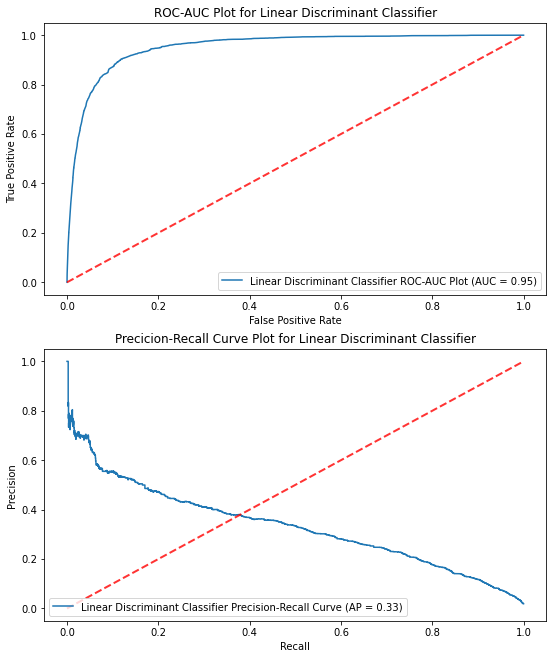



This Classifier took 0 minutes and 1 seconds to train



Quadratic Discriminant Classifier 

Confusion Matrix: 



,Predicted Survived (Class 0),Predicted Died (Class 1)
Actually Survived (Class 0),119387,61180
Actually Died (Class 1),97,3028




              precision    recall  f1-score   support

           0       1.00      0.66      0.80    180567
           1       0.05      0.97      0.09      3125

    accuracy                           0.67    183692
   macro avg       0.52      0.82      0.44    183692
weighted avg       0.98      0.67      0.78    183692
 

Accuracy:  0.666
TPR:       0.969
Precision: 0.047
FPR:       0.953
F1-Score:  0.09
ROC-AUC:   0.815




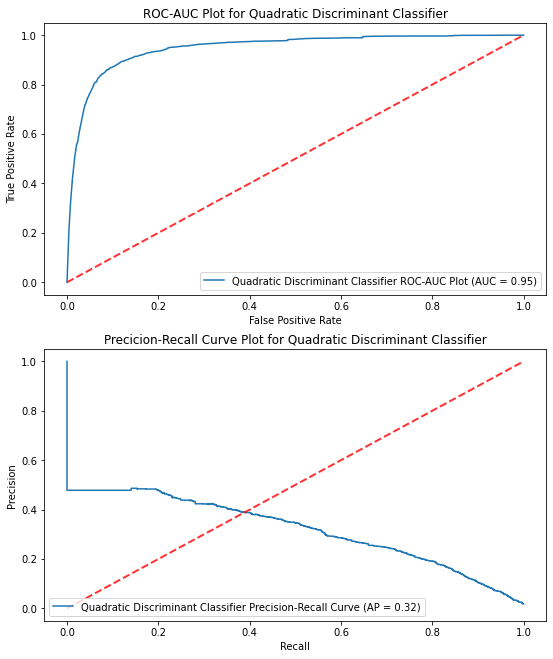



This Classifier took 0 minutes and 1 seconds to train



Logisitc Regression Classifier 

Confusion Matrix: 



,Predicted Survived (Class 0),Predicted Died (Class 1)
Actually Survived (Class 0),161332,19235
Actually Died (Class 1),325,2800




              precision    recall  f1-score   support

           0       1.00      0.89      0.94    180567
           1       0.13      0.90      0.22      3125

    accuracy                           0.89    183692
   macro avg       0.56      0.89      0.58    183692
weighted avg       0.98      0.89      0.93    183692
 

Accuracy:  0.894
TPR:       0.896
Precision: 0.127
FPR:       0.873
F1-Score:  0.223
ROC-AUC:   0.895




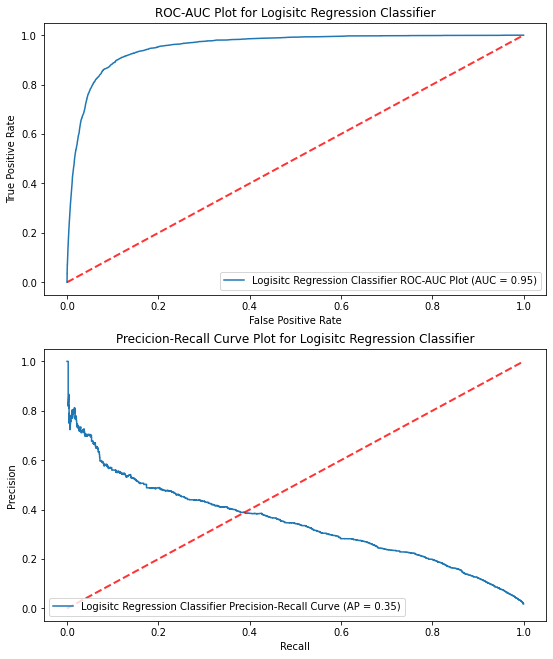



This Classifier took 0 minutes and 10 seconds to train



Gaussian Naive Bayes Classifier 

Confusion Matrix: 



,Predicted Survived (Class 0),Predicted Died (Class 1)
Actually Survived (Class 0),139642,40925
Actually Died (Class 1),158,2967




              precision    recall  f1-score   support

           0       1.00      0.77      0.87    180567
           1       0.07      0.95      0.13      3125

    accuracy                           0.78    183692
   macro avg       0.53      0.86      0.50    183692
weighted avg       0.98      0.78      0.86    183692
 

Accuracy:  0.776
TPR:       0.949
Precision: 0.068
FPR:       0.932
F1-Score:  0.126
ROC-AUC:   0.861




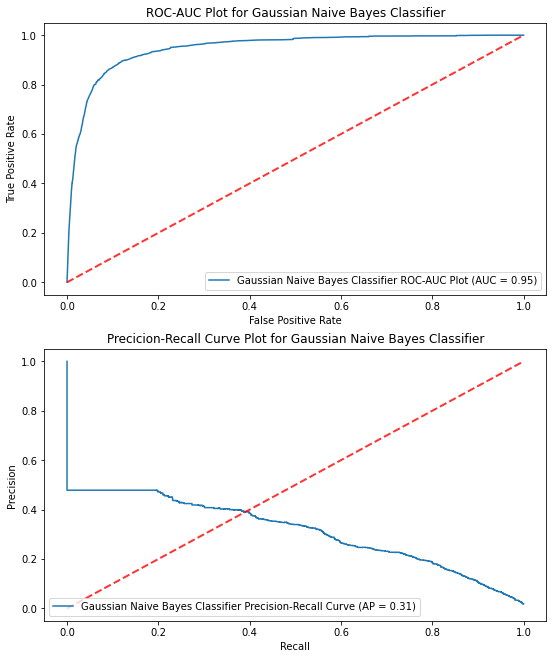



This Classifier took 0 minutes and 0 seconds to train



Decision Tree Classifier 

Confusion Matrix: 



,Predicted Survived (Class 0),Predicted Died (Class 1)
Actually Survived (Class 0),160363,20204
Actually Died (Class 1),326,2799




              precision    recall  f1-score   support

           0       1.00      0.89      0.94    180567
           1       0.12      0.90      0.21      3125

    accuracy                           0.89    183692
   macro avg       0.56      0.89      0.58    183692
weighted avg       0.98      0.89      0.93    183692
 

Accuracy:  0.888
TPR:       0.896
Precision: 0.122
FPR:       0.878
F1-Score:  0.214
ROC-AUC:   0.892




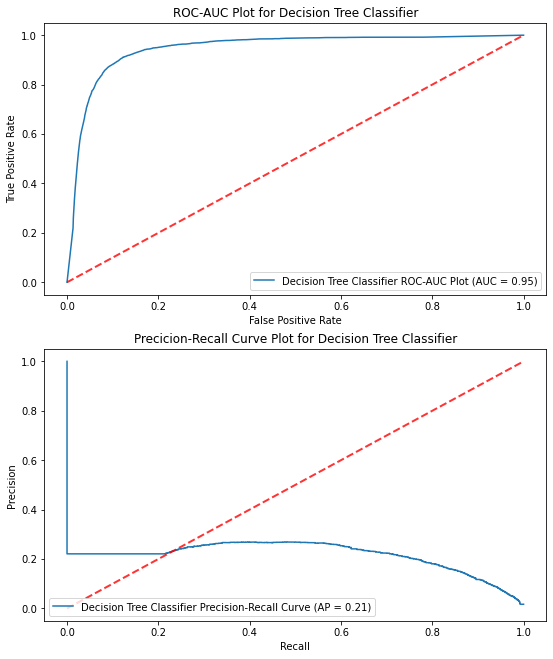



This Classifier took 0 minutes and 1 seconds to train



Stochastic Gradient Descent Classifier 

Confusion Matrix: 



,Predicted Survived (Class 0),Predicted Died (Class 1)
Actually Survived (Class 0),157026,23541
Actually Died (Class 1),302,2823




              precision    recall  f1-score   support

           0       1.00      0.87      0.93    180567
           1       0.11      0.90      0.19      3125

    accuracy                           0.87    183692
   macro avg       0.55      0.89      0.56    183692
weighted avg       0.98      0.87      0.92    183692
 

Accuracy:  0.87
TPR:       0.903
Precision: 0.107
FPR:       0.893
F1-Score:  0.191
ROC-AUC:   0.886




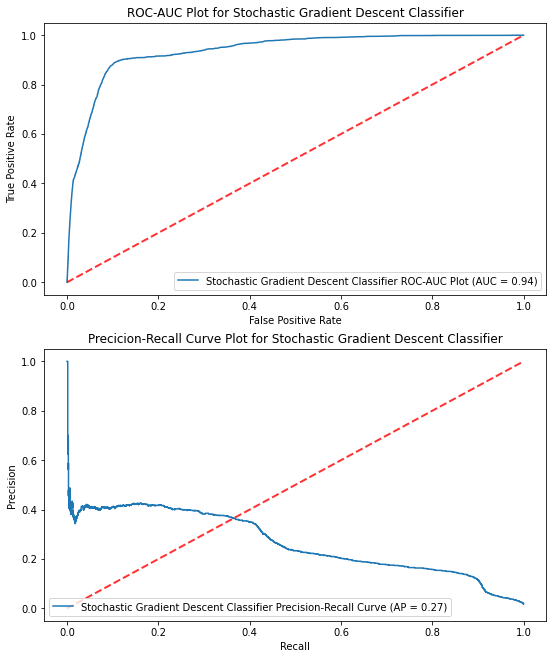



This Classifier took 0 minutes and 2 seconds to train





In [15]:
classifiers = {
    "Linear Discriminant Classifier":          LinearDiscriminantAnalysis(),
    "Quadratic Discriminant Classifier":       QuadraticDiscriminantAnalysis(),
    "Logisitc Regression Classifier":          LogisticRegression(solver='lbfgs',max_iter=1000),
    "Gaussian Naive Bayes Classifier":         GaussianNB(),
    "Decision Tree Classifier":                DecisionTreeClassifier(),
    "Stochastic Gradient Descent Classifier":  SGDClassifier()
}

for key, classifier in classifiers.items():
    
    #try:
    start = time.time()

    classifier.fit(X_train, y_train)
    y_score = classifier.predict(X_test)
    print("="*125)
    print(color.BOLD + color.UNDERLINE + key + color.END, "\n")
    print(color.BOLD + "Confusion Matrix: \n" + color.END)
    conf_mat = pd.DataFrame(confusion_matrix(y_test, y_score))
    conf_mat.index = ['Actually Survived (Class 0)', 'Actually Died (Class 1)']
    conf_mat.columns = ['Predicted Survived (Class 0)', 'Predicted Died (Class 1)']
    display(conf_mat)
    print("\n")
    print(classification_report(y_test, y_score), "\n")
    acc = round(accuracy_score(y_test, y_score), 3)
    rec = round(recall_score(y_test, y_score), 3)
    prec = round(precision_score(y_test, y_score), 3)
    f1score = round(f1_score(y_test, y_score),3)
    roc_auc = round(roc_auc_score(y_test, y_score),3)
    tpr,fpr = TPR_FPR_Score(y_test, y_score)
    tpr,fpr = round(tpr,3), round(fpr,3)
    end = time.time()

    run_time = int(end-start)

    print(color.BOLD + f'Accuracy:  {acc}')
    print(f"TPR:       {tpr}")
    print(f'Precision: {prec}')
    print(f"FPR:       {fpr}")
    print(f"F1-Score:  {f1score}")
    print(f"ROC-AUC:   {roc_auc}" + color.END)
    print("\n")

    fig,axs = plt.subplots(nrows=2,ncols=1,figsize=(9,11))
    axs[0].set_title("ROC-AUC Plot for " + key)
    plot_roc_curve(classifier, X_test, y_test, ax=axs[0], name=key+" ROC-AUC Plot")
    axs[0].plot([0, 1], [0, 1], linestyle='--', lw=2, color='r',
    label='Chance', alpha=.8)
    
    axs[1].set_title("Precicion-Recall Curve Plot for " + key)
    plot_precision_recall_curve(classifier, X_test, y_test, ax=axs[1],name=key+" Precision-Recall Curve")
    axs[1].plot([0, 1], [0, 1], linestyle='--', lw=2, color='r',
    label='Chance', alpha=.8)
    plt.show();

    print("\n")
    print(f"This Classifier took {int(run_time /60)} minutes and {int(run_time % 60)} seconds to train\n")
    print("="*125, '\n\n')

    #except:
     #   continue

### Section 4.2: Defining and Fitting More Complex Classifiers

Random Forest Classifier 

Confusion Matrix: 



,Predicted Survived (Class 0),Predicted Died (Class 1)
Actually Survived (Class 0),160006,20561
Actually Died (Class 1),309,2816




              precision    recall  f1-score   support

           0       1.00      0.89      0.94    180567
           1       0.12      0.90      0.21      3125

    accuracy                           0.89    183692
   macro avg       0.56      0.89      0.58    183692
weighted avg       0.98      0.89      0.93    183692
 

Accuracy:  0.886
TPR:       0.901
Precision: 0.12
FPR:       0.88
F1-Score:  0.213
ROC-AUC:   0.894




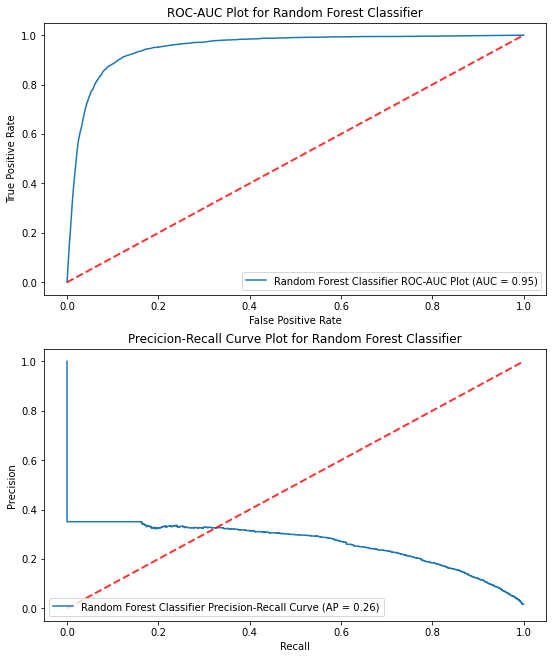



This Classifier took 1 minutes and 4 seconds to train



Multi-Layer Perceptron Classifier 

Confusion Matrix: 



,Predicted Survived (Class 0),Predicted Died (Class 1)
Actually Survived (Class 0),161639,18928
Actually Died (Class 1),332,2793




              precision    recall  f1-score   support

           0       1.00      0.90      0.94    180567
           1       0.13      0.89      0.22      3125

    accuracy                           0.90    183692
   macro avg       0.56      0.89      0.58    183692
weighted avg       0.98      0.90      0.93    183692
 

Accuracy:  0.895
TPR:       0.894
Precision: 0.129
FPR:       0.871
F1-Score:  0.225
ROC-AUC:   0.894




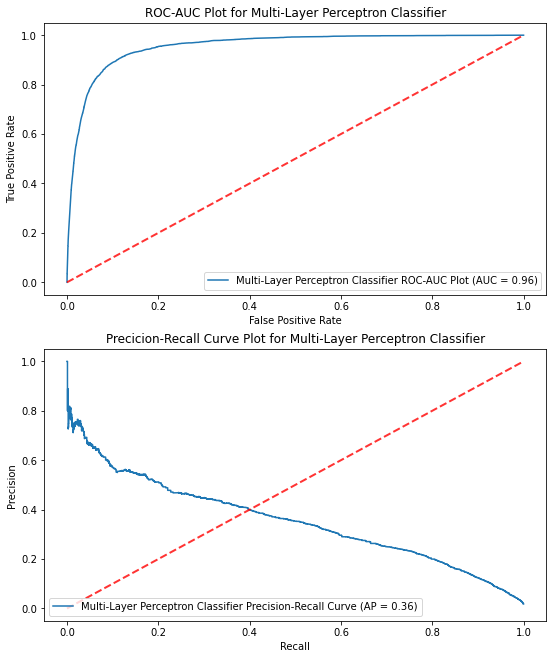



This Classifier took 0 minutes and 45 seconds to train



XGBoost Classifier 

Confusion Matrix: 



,Predicted Survived (Class 0),Predicted Died (Class 1)
Actually Survived (Class 0),159998,20569
Actually Died (Class 1),298,2827




              precision    recall  f1-score   support

           0       1.00      0.89      0.94    180567
           1       0.12      0.90      0.21      3125

    accuracy                           0.89    183692
   macro avg       0.56      0.90      0.58    183692
weighted avg       0.98      0.89      0.93    183692
 

Accuracy:  0.886
TPR:       0.905
Precision: 0.121
FPR:       0.879
F1-Score:  0.213
ROC-AUC:   0.895




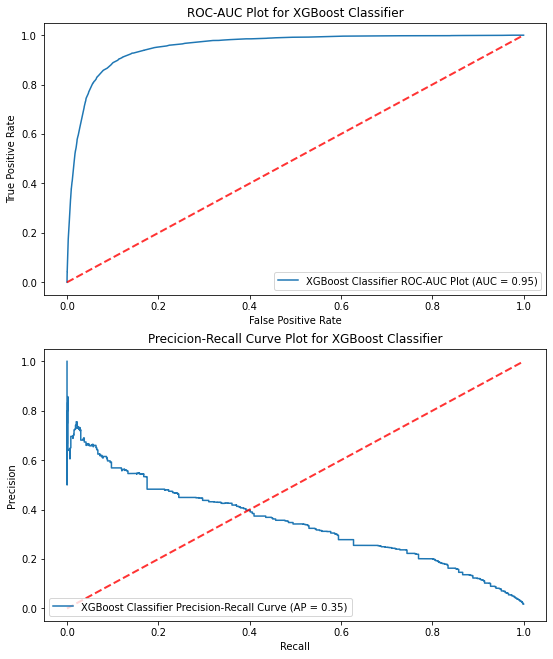



This Classifier took 0 minutes and 26 seconds to train





In [16]:
classifiers = {
    "Random Forest Classifier":                RandomForestClassifier(n_estimators=250),
    "Multi-Layer Perceptron Classifier":       MLPClassifier(hidden_layer_sizes=(24,24,),activation='logistic',max_iter=1000),
    "XGBoost Classifier":                      XGBClassifier()
}

for key, classifier in classifiers.items():
    
    #try:
    start = time.time()

    classifier.fit(X_train, y_train)
    y_score = classifier.predict(X_test)
    print("="*125)
    print(color.BOLD + color.UNDERLINE + key + color.END, "\n")
    print(color.BOLD + "Confusion Matrix: \n" + color.END)
    conf_mat = pd.DataFrame(confusion_matrix(y_test, y_score))
    conf_mat.index = ['Actually Survived (Class 0)', 'Actually Died (Class 1)']
    conf_mat.columns = ['Predicted Survived (Class 0)', 'Predicted Died (Class 1)']
    display(conf_mat)
    print("\n")
    print(classification_report(y_test, y_score), "\n")
    acc = round(accuracy_score(y_test, y_score), 3)
    rec = round(recall_score(y_test, y_score), 3)
    prec = round(precision_score(y_test, y_score), 3)
    f1score = round(f1_score(y_test, y_score),3)
    roc_auc = round(roc_auc_score(y_test, y_score),3)
    tpr,fpr = TPR_FPR_Score(y_test, y_score)
    tpr,fpr = round(tpr,3), round(fpr,3)
    end = time.time()

    run_time = int(end-start)

    print(color.BOLD + f'Accuracy:  {acc}')
    print(f"TPR:       {tpr}")
    print(f'Precision: {prec}')
    print(f"FPR:       {fpr}")
    print(f"F1-Score:  {f1score}")
    print(f"ROC-AUC:   {roc_auc}" + color.END)
    print("\n")

    fig,axs = plt.subplots(nrows=2,ncols=1,figsize=(9,11))
    axs[0].set_title("ROC-AUC Plot for " + key)
    plot_roc_curve(classifier, X_test, y_test, ax=axs[0], name=key+" ROC-AUC Plot")
    axs[0].plot([0, 1], [0, 1], linestyle='--', lw=2, color='r',
    label='Chance', alpha=.8)
    
    axs[1].set_title("Precicion-Recall Curve Plot for " + key)
    plot_precision_recall_curve(classifier, X_test, y_test, ax=axs[1],name=key+" Precision-Recall Curve")
    axs[1].plot([0, 1], [0, 1], linestyle='--', lw=2, color='r',
    label='Chance', alpha=.8)
    plt.show();

    print("\n")
    print(f"This Classifier took {int(run_time /60)} minutes and {int(run_time % 60)} seconds to train\n")
    print("="*125, '\n\n')

    #except:
     #   continue

### Section 4.3: Hyperparameter Tuning on XGBoost Classifier

In [104]:
param_dict = {'max_depth':[3,4], 'n_estimators':[300,400,500,600,700]}

grid = GridSearchCV(estimator=XGBClassifier(), param_grid=param_dict, scoring='f1', n_jobs=3)

grid.fit(X_train, y_train)

grid_results = pd.DataFrame(grid.cv_results_).sort_values(by='rank_test_score')


print("Parameter Grid Searched:")
print(grid)
print("\nBest Score Achieved: ")
print(grid.best_score_)
print("\nBest Estimator Achieved: ")
print(grid.best_estimator_)
print("\nOptimal Parameters")
print(grid_results.head(1)['params'].values)

Parameter Grid Searched:
GridSearchCV(estimator=XGBClassifier(), n_jobs=3,
             param_grid={'max_depth': [3, 4],
                         'n_estimators': [300, 400, 500, 600, 700]},
             scoring='f1')

Best Score Achieved: 
0.9011233854673094

Best Estimator Achieved: 
XGBClassifier(n_estimators=300)

Optimal Parameters
[{'max_depth': 3, 'n_estimators': 300}]


### Section 4.4: Building the Optimized XGBClassifier

XGBoost Classifier 

Confusion Matrix: 



,Predicted Survived (Class 0),Predicted Died (Class 1)
Actually Survived (Class 0),160619,19948
Actually Died (Class 1),309,2816




              precision    recall  f1-score   support

           0       1.00      0.89      0.94    180567
           1       0.12      0.90      0.22      3125

    accuracy                           0.89    183692
   macro avg       0.56      0.90      0.58    183692
weighted avg       0.98      0.89      0.93    183692
 

Accuracy:  0.89
TPR:       0.901
Precision: 0.124
FPR:       0.876
F1-Score:  0.218
ROC-AUC:   0.895




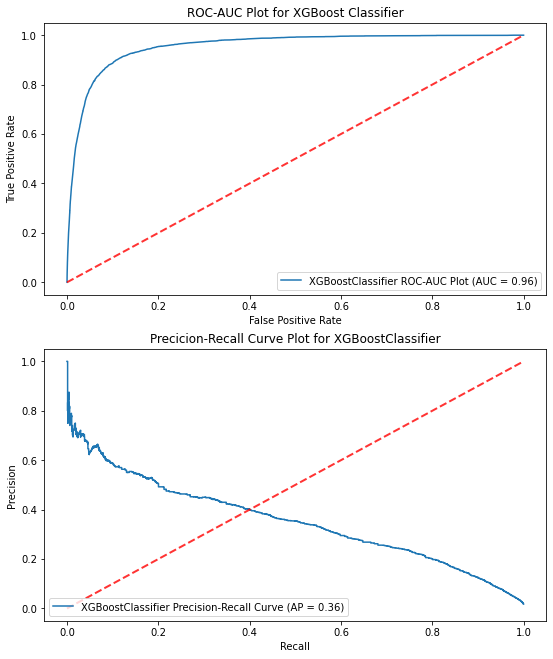



This Classifier took 1 minutes and 11 seconds to train





In [72]:
start = time.time()

classifier = XGBClassifier(n_estimators=300, max_depth=3,random_state=42)

classifier.fit(X_train, y_train)
y_score = classifier.predict(X_test)
print("="*125)
print(color.BOLD + color.UNDERLINE + "XGBoost Classifier" + color.END, "\n")
print(color.BOLD + "Confusion Matrix: \n" + color.END)

conf_mat = pd.DataFrame(confusion_matrix(y_test, y_score))
conf_mat.index = ['Actually Survived (Class 0)', 'Actually Died (Class 1)']
conf_mat.columns = ['Predicted Survived (Class 0)', 'Predicted Died (Class 1)']
display(conf_mat)
print("\n")

print(classification_report(y_test, y_score), "\n")
acc = round(accuracy_score(y_test, y_score), 3)
rec = round(recall_score(y_test, y_score), 3)
prec = round(precision_score(y_test, y_score), 3)
f1score = round(f1_score(y_test, y_score),3)
roc_auc = round(roc_auc_score(y_test, y_score),3)
tpr,fpr = TPR_FPR_Score(y_test, y_score)
tpr,fpr = round(tpr,3), round(fpr,3)
end = time.time()

run_time = int(end-start)

print(color.BOLD + f'Accuracy:  {acc}')
print(f"TPR:       {tpr}")
print(f'Precision: {prec}')
print(f"FPR:       {fpr}")
print(f"F1-Score:  {f1score}")
print(f"ROC-AUC:   {roc_auc}" + color.END)
print("\n")

fig,axs = plt.subplots(nrows=2,ncols=1,figsize=(9,11))
axs[0].set_title("ROC-AUC Plot for " + "XGBoost Classifier")
plot_roc_curve(classifier, X_test, y_test, ax=axs[0], name='XGBoostClassifier'+" ROC-AUC Plot")
axs[0].plot([0, 1], [0, 1], linestyle='--', lw=2, color='r',
label='Chance', alpha=.8)

axs[1].set_title("Precicion-Recall Curve Plot for " + 'XGBoostClassifier')
plot_precision_recall_curve(classifier, X_test, y_test, ax=axs[1],name='XGBoostClassifier'+" Precision-Recall Curve")
axs[1].plot([0, 1], [0, 1], linestyle='--', lw=2, color='r',
label='Chance', alpha=.8)
plt.show();

print("\n")
print(f"This Classifier took {int(run_time /60)} minutes and {int(run_time % 60)} seconds to train\n")
print("="*125, '\n\n')

### Section 4.5: Using Shapley Values to Explain the Model's Decision Making Process

#### Section 4.5.1: Defining The Tree Explainer and Seeing Prediction Explanations for Test Set Values

In [73]:
explainer = shap.TreeExplainer(classifier)
shap_values = explainer.shap_values(X_test)

# visualize the first prediction's explanation (use matplotlib=True to avoid Javascript)
shap.force_plot(explainer.expected_value, shap_values[1], X_test.iloc[1,:],link='logit')

In [74]:
shap.force_plot(explainer.expected_value, shap_values[0], X_test.iloc[0,:],link='logit',figsize=(25,4))

In [75]:
X_test.iloc[0:2,:]

,Symptom_Development_Time,Lab_Confirmed_Case,MedCond_yes,Sex_M,Sex_F,Age_0 - 9 Years,Age_10 - 19 Years,Age_20 - 29 Years,Age_30 - 39 Years,Age_40 - 49 Years,Age_50 - 59 Years,Age_60 - 69 Years,Age_70 - 79 Years,Age_80+ Years,Race_Hispanic/Latino,Race_Black,Race_White,Race_Multiple/Other,Race_Native Hawaiian/Other Pacific Islander,Race_Asian,Race_American Indian/Alaska Native,Hosp_yn,ICU_yn
0,3.000,1,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
1,2.000,1,1,0,1,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0


#### Section 4.5.2: Getting Shapley Summary Plot to Explain Feature Importances

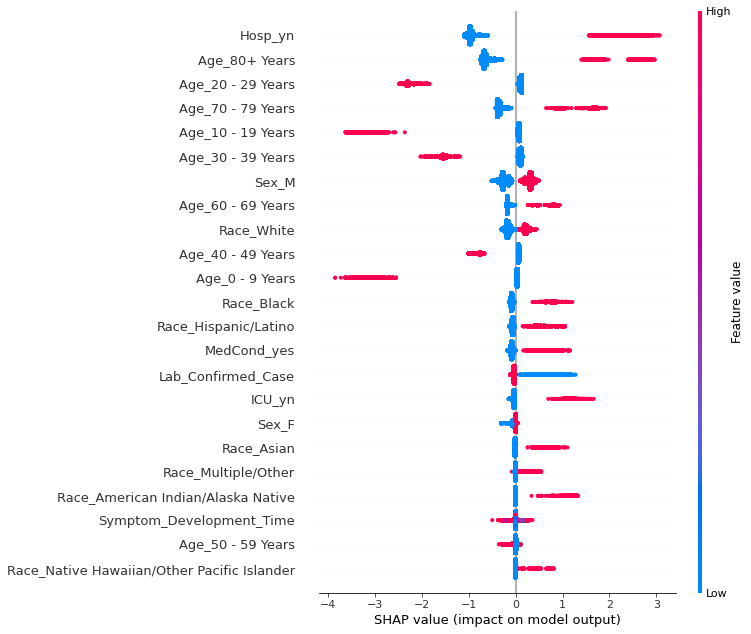

In [79]:
shap.summary_plot(shap_values, X_test,title='SHAP Values for Each Feature', max_display=len(X_test.columns))

### Section 4.6: Pickling the Classifier

In [77]:
import pickle
file_name = "xgb_clf.pkl"

# save
pickle.dump(classifier, open(file_name, "wb"))

# load
xgb_clf = pickle.load(open(file_name, "rb"))

# test
xgb_clf.predict(X_test)[0] == classifier.predict(X_test)[0]

True

## Section 5: Applying the Model to the Test Set

### Section 5.1: Read in and Clean Test Data

In [5]:
testing = pd.read_csv("Testing_Data.csv")
testing.drop(['Dataset','cdc_case_earliest_dt','pos_spec_dt','onset_dt','Time_Since_Pandemic_Start'],axis=1,inplace=True)

testing['Symptom_Development_Time'] = testing['Symptom_Development_Time'].apply(clean_symptom_time)

testing.head()

Columns (1) have mixed types.Specify dtype option on import or set low_memory=False.


,Symptom_Development_Time,Lab_Confirmed_Case,MedCond_yes,Sex_M,Sex_F,Age_0 - 9 Years,Age_10 - 19 Years,Age_20 - 29 Years,Age_30 - 39 Years,Age_40 - 49 Years,Age_50 - 59 Years,Age_60 - 69 Years,Age_70 - 79 Years,Age_80+ Years,Race_Hispanic/Latino,Race_Black,Race_White,Race_Multiple/Other,Race_Native Hawaiian/Other Pacific Islander,Race_Asian,Race_American Indian/Alaska Native,Hosp_yn,ICU_yn,Death_yn
0,2.000,1,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,15.000,1,0,0,1,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0
2,1.000,1,0,1,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0
3,5.000,1,0,0,1,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0
4,2.000,1,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


### Section 5.2: Load Pickled Classifier

In [6]:
import pickle
file_name = "xgb_clf.pkl"

xgb_clf = pickle.load(open(file_name, "rb"))

### Section 5.3: Apply the Classifier to the Test Data

In [7]:
X_final = testing.drop('Death_yn',axis=1)
y_final = testing['Death_yn']

XGBoost Classifier 

Confusion Matrix: 



,Predicted Survived (Class 0),Predicted Died (Class 1)
Actually Survived (Class 0),8119057,1011151
Actually Died (Class 1),13957,142173




              precision    recall  f1-score   support

           0       1.00      0.89      0.94   9130208
           1       0.12      0.91      0.22    156130

    accuracy                           0.89   9286338
   macro avg       0.56      0.90      0.58   9286338
weighted avg       0.98      0.89      0.93   9286338
 

Accuracy:  0.89
TPR:       0.911
Precision: 0.123
FPR:       0.877
F1-Score:  0.217
ROC-AUC:   0.9




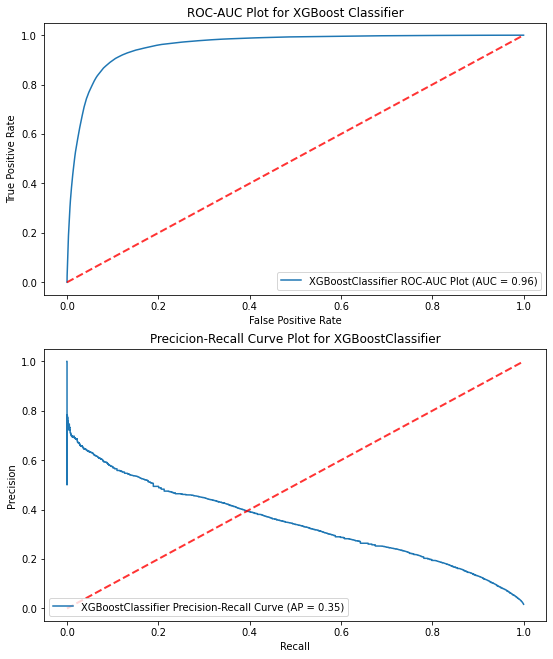



This Classifier took 0 minutes and 43 seconds to run on the Test Set





In [12]:
start = time.time()

y_score = xgb_clf.predict(X_final)
print("="*125)
print(color.BOLD + color.UNDERLINE + "XGBoost Classifier" + color.END, "\n")
print(color.BOLD + "Confusion Matrix: \n" + color.END)

conf_mat = pd.DataFrame(confusion_matrix(y_final, y_score))
conf_mat.index = ['Actually Survived (Class 0)', 'Actually Died (Class 1)']
conf_mat.columns = ['Predicted Survived (Class 0)', 'Predicted Died (Class 1)']
display(conf_mat)
print("\n")

print(classification_report(y_final, y_score), "\n")
acc = round(accuracy_score(y_final, y_score), 3)
rec = round(recall_score(y_final, y_score), 3)
prec = round(precision_score(y_final, y_score), 3)
f1score = round(f1_score(y_final, y_score),3)
roc_auc = round(roc_auc_score(y_final, y_score),3)
tpr,fpr = TPR_FPR_Score(y_final, y_score)
tpr,fpr = round(tpr,3), round(fpr,3)
end = time.time()

run_time = int(end-start)

print(color.BOLD + f'Accuracy:  {acc}')
print(f"TPR:       {tpr}")
print(f'Precision: {prec}')
print(f"FPR:       {fpr}")
print(f"F1-Score:  {f1score}")
print(f"ROC-AUC:   {roc_auc}" + color.END)
print("\n")

fig,axs = plt.subplots(nrows=2,ncols=1,figsize=(9,11))
axs[0].set_title("ROC-AUC Plot for " + "XGBoost Classifier")
plot_roc_curve(xgb_clf, X_final, y_final, ax=axs[0], name='XGBoostClassifier'+" ROC-AUC Plot")
axs[0].plot([0, 1], [0, 1], linestyle='--', lw=2, color='r',
label='Chance', alpha=.8)

axs[1].set_title("Precicion-Recall Curve Plot for " + 'XGBoostClassifier')
plot_precision_recall_curve(xgb_clf, X_final, y_final, ax=axs[1],name='XGBoostClassifier'+" Precision-Recall Curve")
axs[1].plot([0, 1], [0, 1], linestyle='--', lw=2, color='r',
label='Chance', alpha=.8)
plt.show();

print("\n")
print(f"This Classifier took {int(run_time /60)} minutes and {int(run_time % 60)} seconds to run on the Test Set\n")
print("="*125, '\n\n')

### Section 5.4: Finding the Optimal Probability Threshold for the Classifier

In [104]:
testing['Probability'] = pd.DataFrame(xgb_clf.predict_proba(X_final)).iloc[:,1]
testing['40%_Thresh']  = testing['Probability'].apply(lambda x: 1 if x>= 0.40 else 0)
testing['55%_Thresh']  = testing['Probability'].apply(lambda x: 1 if x>= 0.55 else 0)
testing['60%_Thresh']  = testing['Probability'].apply(lambda x: 1 if x>= 0.60 else 0)
testing['65%_Thresh']  = testing['Probability'].apply(lambda x: 1 if x>= 0.65 else 0)
testing['70%_Thresh']  = testing['Probability'].apply(lambda x: 1 if x>= 0.70 else 0)
testing['75%_Thresh']  = testing['Probability'].apply(lambda x: 1 if x>= 0.75 else 0)
testing['80%_Thresh']  = testing['Probability'].apply(lambda x: 1 if x>= 0.80 else 0)
testing['85%_Thresh']  = testing['Probability'].apply(lambda x: 1 if x>= 0.85 else 0)

testing.head()

,Symptom_Development_Time,Lab_Confirmed_Case,MedCond_yes,Sex_M,Sex_F,Age_0 - 9 Years,Age_10 - 19 Years,Age_20 - 29 Years,Age_30 - 39 Years,Age_40 - 49 Years,Age_50 - 59 Years,Age_60 - 69 Years,Age_70 - 79 Years,Age_80+ Years,Race_Hispanic/Latino,Race_Black,Race_White,Race_Multiple/Other,Race_Native Hawaiian/Other Pacific Islander,Race_Asian,Race_American Indian/Alaska Native,Hosp_yn,ICU_yn,Death_yn,Probability,40%_Thresh,55%_Thresh,60%_Thresh,65%_Thresh,70%_Thresh,80%_Thresh,85%_Thresh,75%_Thresh
0,2.000,1,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.003,0,0,0,0,0,0,0,0
1,15.000,1,0,0,1,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0.004,0,0,0,0,0,0,0,0
2,1.000,1,0,1,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0.009,0,0,0,0,0,0,0,0
3,5.000,1,0,0,1,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0.006,0,0,0,0,0,0,0,0
4,2.000,1,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.004,0,0,0,0,0,0,0,0


#### Section 5.4.1: 40%

In [111]:
start = time.time()

y_score = testing['40%_Thresh']
print("="*125)
print(color.BOLD + color.UNDERLINE + "XGBoost Classifier 40% Threshold Class 1" + color.END, "\n")
print(color.BOLD + "Confusion Matrix: \n" + color.END)

conf_mat = pd.DataFrame(confusion_matrix(y_final, y_score))
conf_mat.index = ['Actually Survived (Class 0)', 'Actually Died (Class 1)']
conf_mat.columns = ['Predicted Survived (Class 0)', 'Predicted Died (Class 1)']
display(conf_mat)
print("\n")

print(classification_report(y_final, y_score), "\n")
acc = round(accuracy_score(y_final, y_score), 3)
rec = round(recall_score(y_final, y_score), 3)
prec = round(precision_score(y_final, y_score), 3)
f1score = round(f1_score(y_final, y_score),3)
roc_auc = round(roc_auc_score(y_final, y_score),3)
tpr,fpr = TPR_FPR_Score(y_final, y_score)
tpr,fpr = round(tpr,3), round(fpr,3)

print(color.BOLD + f'Accuracy:  {acc}')
print(f"TPR:       {tpr}")
print(f'Precision: {prec}')
print(f"FPR:       {fpr}")
print(f"F1-Score:  {f1score}")
print(f"ROC-AUC:   {roc_auc}" + color.END)
print("\n")

end = time.time()

run_time = int(end-start)

print("\n")
print(f"This Classifier took {int(run_time /60)} minutes and {int(run_time % 60)} seconds to train\n")
print("="*125, '\n\n')

XGBoost Classifier 40% Threshold Class 1 

Confusion Matrix: 



,Predicted Survived (Class 0),Predicted Died (Class 1)
Actually Survived (Class 0),7892887,1237321
Actually Died (Class 1),10853,145277




              precision    recall  f1-score   support

           0       1.00      0.86      0.93   9130208
           1       0.11      0.93      0.19    156130

    accuracy                           0.87   9286338
   macro avg       0.55      0.90      0.56   9286338
weighted avg       0.98      0.87      0.91   9286338
 

Accuracy:  0.866
TPR:       0.93
Precision: 0.105
FPR:       0.895
F1-Score:  0.189
ROC-AUC:   0.897




This Classifier took 0 minutes and 30 seconds to train





#### Section 5.4.2: 55%

In [112]:
start = time.time()

y_score = testing['55%_Thresh']
print("="*125)
print(color.BOLD + color.UNDERLINE + "XGBoost Classifier 55% Threshold Class 1" + color.END, "\n")
print(color.BOLD + "Confusion Matrix: \n" + color.END)

conf_mat = pd.DataFrame(confusion_matrix(y_final, y_score))
conf_mat.index = ['Actually Survived (Class 0)', 'Actually Died (Class 1)']
conf_mat.columns = ['Predicted Survived (Class 0)', 'Predicted Died (Class 1)']
display(conf_mat)
print("\n")

print(classification_report(y_final, y_score), "\n")
acc = round(accuracy_score(y_final, y_score), 3)
rec = round(recall_score(y_final, y_score), 3)
prec = round(precision_score(y_final, y_score), 3)
f1score = round(f1_score(y_final, y_score),3)
roc_auc = round(roc_auc_score(y_final, y_score),3)
tpr,fpr = TPR_FPR_Score(y_final, y_score)
tpr,fpr = round(tpr,3), round(fpr,3)

print(color.BOLD + f'Accuracy:  {acc}')
print(f"TPR:       {tpr}")
print(f'Precision: {prec}')
print(f"FPR:       {fpr}")
print(f"F1-Score:  {f1score}")
print(f"ROC-AUC:   {roc_auc}" + color.END)
print("\n")

end = time.time()

run_time = int(end-start)

print("\n")
print(f"This Classifier took {int(run_time /60)} minutes and {int(run_time % 60)} seconds to train\n")
print("="*125, '\n\n')

XGBoost Classifier 55% Threshold Class 1 

Confusion Matrix: 



,Predicted Survived (Class 0),Predicted Died (Class 1)
Actually Survived (Class 0),8177775,952433
Actually Died (Class 1),15039,141091




              precision    recall  f1-score   support

           0       1.00      0.90      0.94   9130208
           1       0.13      0.90      0.23    156130

    accuracy                           0.90   9286338
   macro avg       0.56      0.90      0.58   9286338
weighted avg       0.98      0.90      0.93   9286338
 

Accuracy:  0.896
TPR:       0.904
Precision: 0.129
FPR:       0.871
F1-Score:  0.226
ROC-AUC:   0.9




This Classifier took 0 minutes and 30 seconds to train





#### Section 5.4.3: 60%

In [113]:
start = time.time()

y_score = testing['60%_Thresh']
print("="*125)
print(color.BOLD + color.UNDERLINE + "XGBoost Classifier 60% Threshold Class 1" + color.END, "\n")
print(color.BOLD + "Confusion Matrix: \n" + color.END)

conf_mat = pd.DataFrame(confusion_matrix(y_final, y_score))
conf_mat.index = ['Actually Survived (Class 0)', 'Actually Died (Class 1)']
conf_mat.columns = ['Predicted Survived (Class 0)', 'Predicted Died (Class 1)']
display(conf_mat)
print("\n")

print(classification_report(y_final, y_score), "\n")
acc = round(accuracy_score(y_final, y_score), 3)
rec = round(recall_score(y_final, y_score), 3)
prec = round(precision_score(y_final, y_score), 3)
f1score = round(f1_score(y_final, y_score),3)
roc_auc = round(roc_auc_score(y_final, y_score),3)
tpr,fpr = TPR_FPR_Score(y_final, y_score)
tpr,fpr = round(tpr,3), round(fpr,3)

print(color.BOLD + f'Accuracy:  {acc}')
print(f"TPR:       {tpr}")
print(f'Precision: {prec}')
print(f"FPR:       {fpr}")
print(f"F1-Score:  {f1score}")
print(f"ROC-AUC:   {roc_auc}" + color.END)
print("\n")

end = time.time()

run_time = int(end-start)

print("\n")
print(f"This Classifier took {int(run_time /60)} minutes and {int(run_time % 60)} seconds to train\n")
print("="*125, '\n\n')

XGBoost Classifier 60% Threshold Class 1 

Confusion Matrix: 



,Predicted Survived (Class 0),Predicted Died (Class 1)
Actually Survived (Class 0),8282961,847247
Actually Died (Class 1),17440,138690




              precision    recall  f1-score   support

           0       1.00      0.91      0.95   9130208
           1       0.14      0.89      0.24    156130

    accuracy                           0.91   9286338
   macro avg       0.57      0.90      0.60   9286338
weighted avg       0.98      0.91      0.94   9286338
 

Accuracy:  0.907
TPR:       0.888
Precision: 0.141
FPR:       0.859
F1-Score:  0.243
ROC-AUC:   0.898




This Classifier took 0 minutes and 31 seconds to train





#### Section 5.4.4: 65%

In [114]:
start = time.time()

y_score = testing['65%_Thresh']
print("="*125)
print(color.BOLD + color.UNDERLINE + "XGBoost Classifier 65% Threshold Class 1" + color.END, "\n")
print(color.BOLD + "Confusion Matrix: \n" + color.END)

conf_mat = pd.DataFrame(confusion_matrix(y_final, y_score))
conf_mat.index = ['Actually Survived (Class 0)', 'Actually Died (Class 1)']
conf_mat.columns = ['Predicted Survived (Class 0)', 'Predicted Died (Class 1)']
display(conf_mat)
print("\n")

print(classification_report(y_final, y_score), "\n")
acc = round(accuracy_score(y_final, y_score), 3)
rec = round(recall_score(y_final, y_score), 3)
prec = round(precision_score(y_final, y_score), 3)
f1score = round(f1_score(y_final, y_score),3)
roc_auc = round(roc_auc_score(y_final, y_score),3)
tpr,fpr = TPR_FPR_Score(y_final, y_score)
tpr,fpr = round(tpr,3), round(fpr,3)

print(color.BOLD + f'Accuracy:  {acc}')
print(f"TPR:       {tpr}")
print(f'Precision: {prec}')
print(f"FPR:       {fpr}")
print(f"F1-Score:  {f1score}")
print(f"ROC-AUC:   {roc_auc}" + color.END)
print("\n")

end = time.time()

run_time = int(end-start)

print("\n")
print(f"This Classifier took {int(run_time /60)} minutes and {int(run_time % 60)} seconds to train\n")
print("="*125, '\n\n')

XGBoost Classifier 65% Threshold Class 1 

Confusion Matrix: 



,Predicted Survived (Class 0),Predicted Died (Class 1)
Actually Survived (Class 0),8407073,723135
Actually Died (Class 1),20939,135191




              precision    recall  f1-score   support

           0       1.00      0.92      0.96   9130208
           1       0.16      0.87      0.27    156130

    accuracy                           0.92   9286338
   macro avg       0.58      0.89      0.61   9286338
weighted avg       0.98      0.92      0.95   9286338
 

Accuracy:  0.92
TPR:       0.866
Precision: 0.158
FPR:       0.842
F1-Score:  0.267
ROC-AUC:   0.893




This Classifier took 0 minutes and 30 seconds to train





#### Section 5.4.5: 70%

In [115]:
start = time.time()

y_score = testing['70%_Thresh']
print("="*125)
print(color.BOLD + color.UNDERLINE + "XGBoost Classifier 70% Threshold Class 1" + color.END, "\n")
print(color.BOLD + "Confusion Matrix: \n" + color.END)

conf_mat = pd.DataFrame(confusion_matrix(y_final, y_score))
conf_mat.index = ['Actually Survived (Class 0)', 'Actually Died (Class 1)']
conf_mat.columns = ['Predicted Survived (Class 0)', 'Predicted Died (Class 1)']
display(conf_mat)
print("\n")

print(classification_report(y_final, y_score), "\n")
acc = round(accuracy_score(y_final, y_score), 3)
rec = round(recall_score(y_final, y_score), 3)
prec = round(precision_score(y_final, y_score), 3)
f1score = round(f1_score(y_final, y_score),3)
roc_auc = round(roc_auc_score(y_final, y_score),3)
tpr,fpr = TPR_FPR_Score(y_final, y_score)
tpr,fpr = round(tpr,3), round(fpr,3)

print(color.BOLD + f'Accuracy:  {acc}')
print(f"TPR:       {tpr}")
print(f'Precision: {prec}')
print(f"FPR:       {fpr}")
print(f"F1-Score:  {f1score}")
print(f"ROC-AUC:   {roc_auc}" + color.END)
print("\n")

end = time.time()

run_time = int(end-start)

print("\n")
print(f"This Classifier took {int(run_time /60)} minutes and {int(run_time % 60)} seconds to train\n")
print("="*125, '\n\n')

XGBoost Classifier 70% Threshold Class 1 

Confusion Matrix: 



,Predicted Survived (Class 0),Predicted Died (Class 1)
Actually Survived (Class 0),8506469,623739
Actually Died (Class 1),24950,131180




              precision    recall  f1-score   support

           0       1.00      0.93      0.96   9130208
           1       0.17      0.84      0.29    156130

    accuracy                           0.93   9286338
   macro avg       0.59      0.89      0.63   9286338
weighted avg       0.98      0.93      0.95   9286338
 

Accuracy:  0.93
TPR:       0.84
Precision: 0.174
FPR:       0.826
F1-Score:  0.288
ROC-AUC:   0.886




This Classifier took 0 minutes and 30 seconds to train





#### Section 5.4.6: 75%

In [116]:
start = time.time()

y_score = testing['75%_Thresh']
print("="*125)
print(color.BOLD + color.UNDERLINE + "XGBoost Classifier 75% Threshold Class 1" + color.END, "\n")
print(color.BOLD + "Confusion Matrix: \n" + color.END)

conf_mat = pd.DataFrame(confusion_matrix(y_final, y_score))
conf_mat.index = ['Actually Survived (Class 0)', 'Actually Died (Class 1)']
conf_mat.columns = ['Predicted Survived (Class 0)', 'Predicted Died (Class 1)']
display(conf_mat)
print("\n")

print(classification_report(y_final, y_score), "\n")
acc = round(accuracy_score(y_final, y_score), 3)
rec = round(recall_score(y_final, y_score), 3)
prec = round(precision_score(y_final, y_score), 3)
f1score = round(f1_score(y_final, y_score),3)
roc_auc = round(roc_auc_score(y_final, y_score),3)
tpr,fpr = TPR_FPR_Score(y_final, y_score)
tpr,fpr = round(tpr,3), round(fpr,3)

print(color.BOLD + f'Accuracy:  {acc}')
print(f"TPR:       {tpr}")
print(f'Precision: {prec}')
print(f"FPR:       {fpr}")
print(f"F1-Score:  {f1score}")
print(f"ROC-AUC:   {roc_auc}" + color.END)
print("\n")

end = time.time()

run_time = int(end-start)

print("\n")
print(f"This Classifier took {int(run_time /60)} minutes and {int(run_time % 60)} seconds to train\n")
print("="*125, '\n\n')

XGBoost Classifier 75% Threshold Class 1 

Confusion Matrix: 



,Predicted Survived (Class 0),Predicted Died (Class 1)
Actually Survived (Class 0),8559424,570784
Actually Died (Class 1),27364,128766




              precision    recall  f1-score   support

           0       1.00      0.94      0.97   9130208
           1       0.18      0.82      0.30    156130

    accuracy                           0.94   9286338
   macro avg       0.59      0.88      0.63   9286338
weighted avg       0.98      0.94      0.96   9286338
 

Accuracy:  0.936
TPR:       0.825
Precision: 0.184
FPR:       0.816
F1-Score:  0.301
ROC-AUC:   0.881




This Classifier took 0 minutes and 30 seconds to train





#### Section 5.4.7: 80%

In [117]:
start = time.time()

y_score = testing['80%_Thresh']
print("="*125)
print(color.BOLD + color.UNDERLINE + "XGBoost Classifier 80% Threshold Class 1" + color.END, "\n")
print(color.BOLD + "Confusion Matrix: \n" + color.END)

conf_mat = pd.DataFrame(confusion_matrix(y_final, y_score))
conf_mat.index = ['Actually Survived (Class 0)', 'Actually Died (Class 1)']
conf_mat.columns = ['Predicted Survived (Class 0)', 'Predicted Died (Class 1)']
display(conf_mat)
print("\n")

print(classification_report(y_final, y_score), "\n")
acc = round(accuracy_score(y_final, y_score), 3)
rec = round(recall_score(y_final, y_score), 3)
prec = round(precision_score(y_final, y_score), 3)
f1score = round(f1_score(y_final, y_score),3)
roc_auc = round(roc_auc_score(y_final, y_score),3)
tpr,fpr = TPR_FPR_Score(y_final, y_score)
tpr,fpr = round(tpr,3), round(fpr,3)

print(color.BOLD + f'Accuracy:  {acc}')
print(f"TPR:       {tpr}")
print(f'Precision: {prec}')
print(f"FPR:       {fpr}")
print(f"F1-Score:  {f1score}")
print(f"ROC-AUC:   {roc_auc}" + color.END)
print("\n")

end = time.time()

run_time = int(end-start)

print("\n")
print(f"This Classifier took {int(run_time /60)} minutes and {int(run_time % 60)} seconds to train\n")
print("="*125, '\n\n')

XGBoost Classifier 80% Threshold Class 1 

Confusion Matrix: 



,Predicted Survived (Class 0),Predicted Died (Class 1)
Actually Survived (Class 0),8680446,449762
Actually Died (Class 1),35118,121012




              precision    recall  f1-score   support

           0       1.00      0.95      0.97   9130208
           1       0.21      0.78      0.33    156130

    accuracy                           0.95   9286338
   macro avg       0.60      0.86      0.65   9286338
weighted avg       0.98      0.95      0.96   9286338
 

Accuracy:  0.948
TPR:       0.775
Precision: 0.212
FPR:       0.788
F1-Score:  0.333
ROC-AUC:   0.863




This Classifier took 0 minutes and 31 seconds to train





#### Section 5.4.8: 85%

In [118]:
start = time.time()

y_score = testing['85%_Thresh']
print("="*125)
print(color.BOLD + color.UNDERLINE + "XGBoost Classifier 85% Threshold Class 1" + color.END, "\n")
print(color.BOLD + "Confusion Matrix: \n" + color.END)

conf_mat = pd.DataFrame(confusion_matrix(y_final, y_score))
conf_mat.index = ['Actually Survived (Class 0)', 'Actually Died (Class 1)']
conf_mat.columns = ['Predicted Survived (Class 0)', 'Predicted Died (Class 1)']
display(conf_mat)
print("\n")

print(classification_report(y_final, y_score), "\n")
acc = round(accuracy_score(y_final, y_score), 3)
rec = round(recall_score(y_final, y_score), 3)
prec = round(precision_score(y_final, y_score), 3)
f1score = round(f1_score(y_final, y_score),3)
roc_auc = round(roc_auc_score(y_final, y_score),3)
tpr,fpr = TPR_FPR_Score(y_final, y_score)
tpr,fpr = round(tpr,3), round(fpr,3)

print(color.BOLD + f'Accuracy:  {acc}')
print(f"TPR:       {tpr}")
print(f'Precision: {prec}')
print(f"FPR:       {fpr}")
print(f"F1-Score:  {f1score}")
print(f"ROC-AUC:   {roc_auc}" + color.END)
print("\n")

end = time.time()

run_time = int(end-start)

print("\n")
print(f"This Classifier took {int(run_time /60)} minutes and {int(run_time % 60)} seconds to train\n")
print("="*125, '\n\n')

XGBoost Classifier 85% Threshold Class 1 

Confusion Matrix: 



,Predicted Survived (Class 0),Predicted Died (Class 1)
Actually Survived (Class 0),8745784,384424
Actually Died (Class 1),40435,115695




              precision    recall  f1-score   support

           0       1.00      0.96      0.98   9130208
           1       0.23      0.74      0.35    156130

    accuracy                           0.95   9286338
   macro avg       0.61      0.85      0.66   9286338
weighted avg       0.98      0.95      0.97   9286338
 

Accuracy:  0.954
TPR:       0.741
Precision: 0.231
FPR:       0.769
F1-Score:  0.353
ROC-AUC:   0.849




This Classifier took 0 minutes and 30 seconds to train





### Section 5.5: Define a Function to Create a vector of values to be fed into the model for prediction

In [72]:
def prepare_prediction_data(symptom_time=4, lab_case=1, med_cond=0, race='White', gender='Male', age=30, hospital=0, icu=0):
    
    """
    Function Name: prepare_prediction_data
    
    Arguments:
    
    - symptom_time: int. An integer that represents the number of days that it took for COVID-19 Symptoms to develop.
    
    - lab_case: int. A 1 or 0 flag to indicate if the COVID case was detected via lab results, or just a probable case without
                     the person actually getting a test.
                     
    - med_cond: int. A 1 or 0 flag to indicate if the patient had an underlying health condition.
    
    - race: str. A string that represents the race of the patient. The acceptable inputs to this argument are one of
                 ['White','Black','Hispanic','Asian','Multiple','Native Hawaiian/Pacific Islander','Indigenous']. Unknown
                 race is the reference category.
                 
    - gender: str. A string representing the gender of the patient. Should be one of ['Male','Female']. Unknown/Other gender
                   is the reference category
                   
    - age: int. An integer that represents the age of the patient in years.
    
    - hospital: int. A 1 or 0 flag indicating if the patient was hospitalized for symptoms related to COVID-19
    
    - icu: int. A 1 or 0 flag indicating if the patitent was placed in an ICU for symptoms related to COVID-19
    
    Description:
    
    This function takes in arguments about an individual patient's COVID-19 Symptoms, demographic information, and hospitalization
    status, and returns a Pandas DataFrame with one row that represents the input vector that will be passed into the trained
    XGBClassifier Model.
    """
    
    
    pred_frame = pd.DataFrame(data={'Symptom_Development_Time':np.nan}, index=[0])
    
    pred_frame['Symptom_Development_Time'] = int(symptom_time)
    pred_frame['Lab_Confirmed_Case'] = int(lab_case)
    pred_frame['MedCond_yes'] = int(med_cond)
    pred_frame['Sex_M'] = np.where(gender == 'Male',   [1],[0])
    pred_frame['Sex_F'] = np.where(gender == 'Female', [1],[0])
    pred_frame['Age_0 - 9 Years']   = np.where(age < 10, [1],[0])
    pred_frame['Age_10 - 19 Years'] = np.where(age >= 10 and age < 20, [1],[0])
    pred_frame['Age_20 - 29 Years'] = np.where(age >= 20 and age < 30, [1],[0])
    pred_frame['Age_30 - 39 Years'] = np.where(age >= 30 and age < 40, [1],[0])
    pred_frame['Age_40 - 49 Years'] = np.where(age >= 40 and age < 50, [1],[0])
    pred_frame['Age_50 - 59 Years'] = np.where(age >= 50 and age < 60, [1],[0])
    pred_frame['Age_60 - 69 Years'] = np.where(age >= 60 and age < 70, [1],[0])
    pred_frame['Age_70 - 79 Years'] = np.where(age >= 70 and age <80, [1],[0])
    pred_frame['Age_80+ Years']     = np.where(age >= 80, [1],[0])
    pred_frame['Race_Hispanic/Latino'] = np.where(race == 'Hispanic', [1],[0])
    pred_frame['Race_Black']           = np.where(race == 'Black', [1],[0])
    pred_frame['Race_White']           = np.where(race == 'White', [1],[0])
    pred_frame['Race_Multiple/Other']  = np.where(race == 'Multiple', [1],[0])
    pred_frame['Race_Native Hawaiian/Other Pacific Islander'] = np.where(race == 'Native Hawaiian/Pacific Islander', [1],[0])
    pred_frame['Race_Asian']           = np.where(race == 'Asian', [1],[0])
    pred_frame['Race_American Indian/Alaska Native']          = np.where(race == 'Indigneous', [1],[0])
    pred_frame['Hosp_yn'] = int(hospital)
    pred_frame['ICU_yn'] = int(icu)
    
    return pred_frame
